In [1]:
from eigen_rootfinding.utils import condeigs
from eigen_rootfinding.polyroots import solve
from eigen_rootfinding.Multiplication import *
import eigen_rootfinding as er
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from tests.devastating_example_test_scripts import *
from tests.conditioning_ratios import *
from scipy.stats import linregress
from scipy.spatial.distance import pdist
%load_ext autoreload
%autoreload 2

#### From Hayden's JMM Presentation:

Recall that the condition number of a simple root $z$ of $f:\mathbb{R}^n\mapsto\mathbb{R}^n$ is:
    $$\kappa(z,f) = \left\lVert{Df(z)^{-1}}\right\rVert_2$$
and that the condition number of a simple eigenvalue $\lambda$ of A such that $Ax = \lambda x$ and $A^*y = \lambda y$ is:
    $$\kappa(\lambda,A) = \frac{\left\lVert{x}\right\rVert \left\lVert{y}\right\rVert}{|y^*x|}$$
    
Define the **conditioning ratio** for a M\"oller-Stetter eigenproblem for an eigenvalue $\lambda$ corresponding to a root $z$ to be:
    $$GF(\lambda,z,f,m_h) = \log_{10}\frac{\kappa(\lambda,m_h)}{\kappa(z,f)}$$
    
This measures how many additional digits of precision may be lost when converting the root-finding problem into an eigenproblem.

# loading in saved data

### random systems

In [2]:
folder = 'tests/conditioning_ratios/rand/newton/'
normal_masks = {d:~np.load(folder+f'dim{d}/not_full_roots_deg2.npy')\
                for d in range(3,7)}
normal_masks[7] = np.ones(200,dtype=bool)
normal_masks[2] = np.ones(300,dtype=bool)
rand_polished = {d:np.stack(np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)[normal_masks[d]])
                      for d in range(2,8)}
rand_polished[8] = np.stack([np.load(folder+f'dim8/deg2_sys{i}.npy')
                                 for i in range(23)])
for d in rand_polished.keys():
    print(rand_polished[d].shape)

(300, 2, 4)
(295, 3, 8)
(298, 4, 16)
(298, 5, 32)
(198, 6, 64)
(200, 7, 128)
(23, 8, 256)


### devastating systems

In [3]:
folder = 'tests/conditioning_ratios/dev/newton/'
dev_polished = {d:np.stack(np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True))
                      for d in range(2,7)}
dev_polished[7] = [np.load(folder+f'dim7/deg2_sys{i}.npy',
                                    allow_pickle=True)
                                 for i in range(45)]
dev_polished[8] = [np.load(folder+f'dim8/deg2_sys{i}.npy',
                                    allow_pickle=True)
                                 for i in range(25)]
#I accidentally saved the converging root info-- so let's check that out now and then remove it
for d in dev_polished.keys():
    for i,sys in enumerate(dev_polished[d]):
        if d > 6:
            sys = sys[0]
        gf,newt_dist,root_dist = sys
        if not 10*newt_dist < root_dist:
            print(d,i)
            print('**Potentially converging roots with polishing**')
            print(f'\tNewton changed roots by at most: {newt_dist}')
            print(f'\tDist between root was at least:  {root_dist}')
    dev_polished[d] = np.array([sys[0] for sys in dev_polished[d]])
for d in [7,8]:
    dev_polished[d] = np.array([sys[0] for sys in dev_polished[d]])
for d in dev_polished.keys():
    print(dev_polished[d].shape)  

(50, 2)
(50, 3)
(50, 4)
(50, 5)
(50, 6)
(45, 7)
(25, 8)


Random Systems
Slope: 0.042297149196839905 
Intercept: 0.24599742391990143 
Exponential Growth Rate: 0.10229325309549786

Devastating Systems, $\epsilon=10^{-1}$
Slope: 1.0000433894444425 
Intercept: -0.9981340387625659 
Exponential Growth Rate: 9.000999128789259



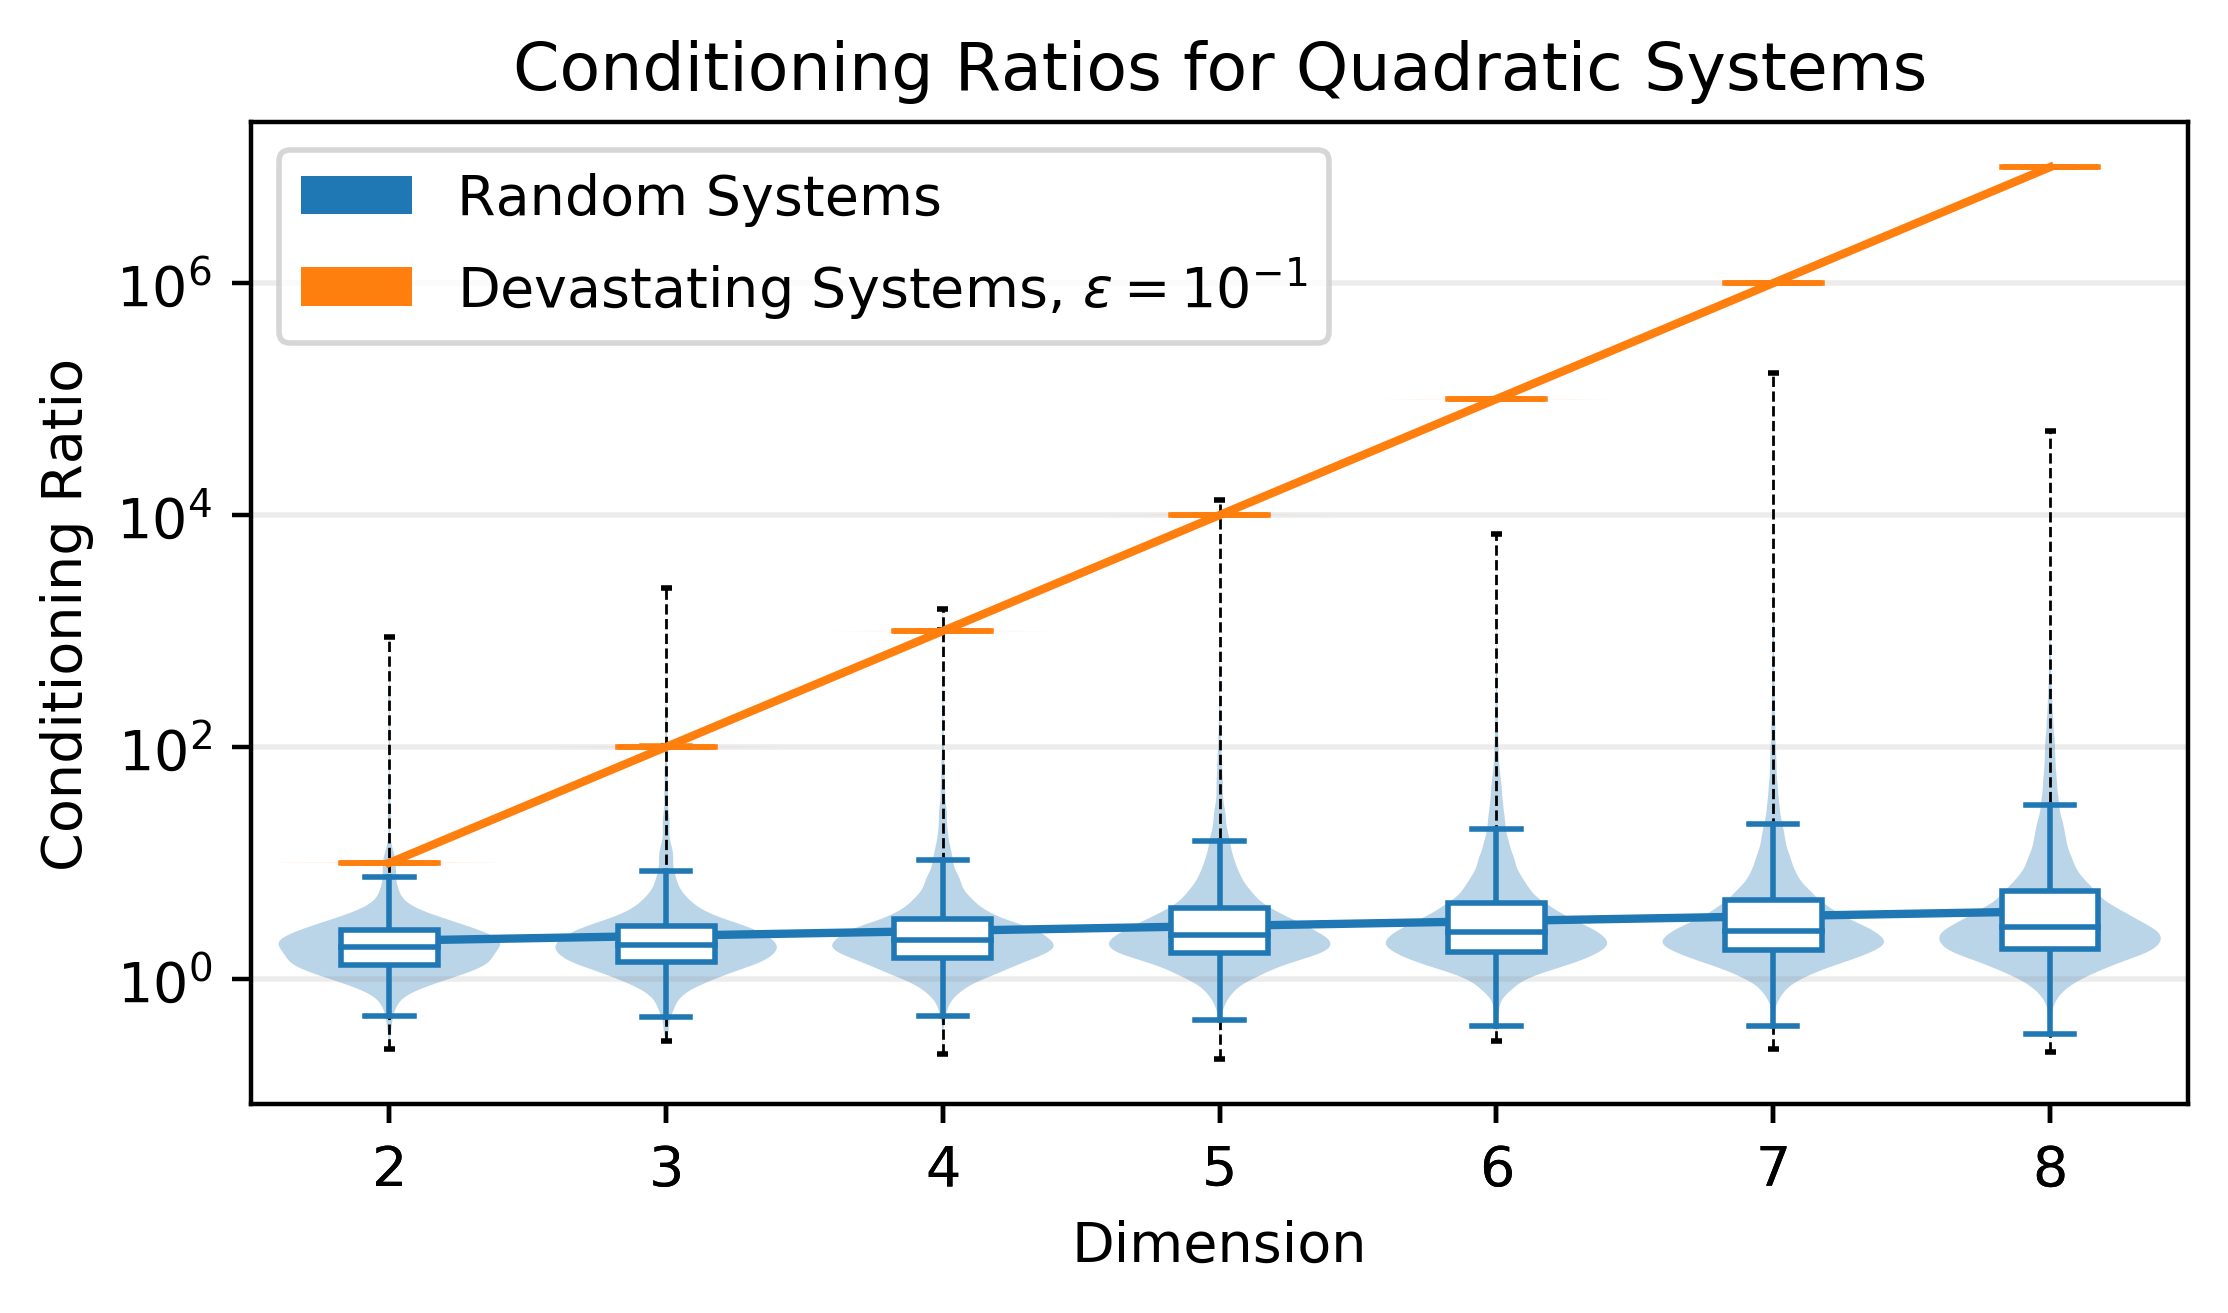

In [4]:
plot([rand_polished,dev_polished],
     ['Random Systems',r'Devastating Systems, $\epsilon=10^{-1}$'],
     figsize=(6.25,3.25), filename='rand_dev', title='Conditioning Ratios for Quadratic Systems')

### comparison to without polishing

folder = 'tests/conditioning_ratios/rand/nopol/'
normal_masks_nopol = {d:~np.load(folder+f'dim{d}/not_full_roots_deg2.npy') for d in range(3,5)}
normal_masks_nopol[2] = np.ones(300,dtype=bool)
rand_nopol = {d:np.stack(np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)[normal_masks_nopol[d]])
                      for d in range(2,5)}
for d in rand_nopol.keys():
    print(rand_nopol[d].shape)

folder = 'tests/conditioning_ratios/dev/nopol/'
dev_nopol = {d:np.stack(np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True))
                      for d in range(2,5)}
for d in dev_nopol.keys():
    print(dev_nopol[d].shape)  

summary: it was practically the same, but polishing the denominator (root) did seem to make it ever so slightly more accurate, so let's go with that.

# perturbing the devastating example

In [5]:
dev_1 = devestating_conditioning_ratios([2,3,4,5],.1,'power',newton=False,save=False,detailed=False)

In [6]:
dev_2 = devestating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False)

In [7]:
dev_2_delta_1 = devestating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.1)

In [8]:
dev_2_delta_2 = devestating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.01)


In [9]:
dev_2_delta_3 = devestating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.001)

In [10]:
dev_2_delta_4 = devestating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.0001)

In [11]:
dev_2_delta_5 = devestating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.00001)

devastating Systems, $\epsilon=.01$
Slope: 1.9999992674663203 
Intercept: -1.9999754282694306 
Exponential Growth Rate: 98.99983132802915

Perturbed devastating Systems, $\epsilon=.01, \delta=.00001$
Slope: 1.993731058425459 
Intercept: -2.0362173928208405 
Exponential Growth Rate: 97.56689104204969

Perturbed devastating Systems, $\epsilon=.01, \delta=.0001$
Slope: 1.7442352853374472 
Intercept: -1.8051239186420096 
Exponential Growth Rate: 54.49262708943212

Perturbed devastating Systems, $\epsilon=.01, \delta=.001$
Slope: 1.3208443661402682 
Intercept: -1.440407739258664 
Exponential Growth Rate: 19.933621437301504

Perturbed devastating Systems, $\epsilon=.01, \delta=.01$
Slope: 0.904524268145805 
Intercept: -1.044416834229024 
Exponential Growth Rate: 7.026464110761751

Perturbed devastating Systems, $\epsilon=.01, \delta=.1$
Slope: 0.3222552782990102 
Intercept: -0.2997958214860865 
Exponential Growth Rate: 1.1001740031716354

Random Systems
Slope: 0.06028422307553604 
Intercept:

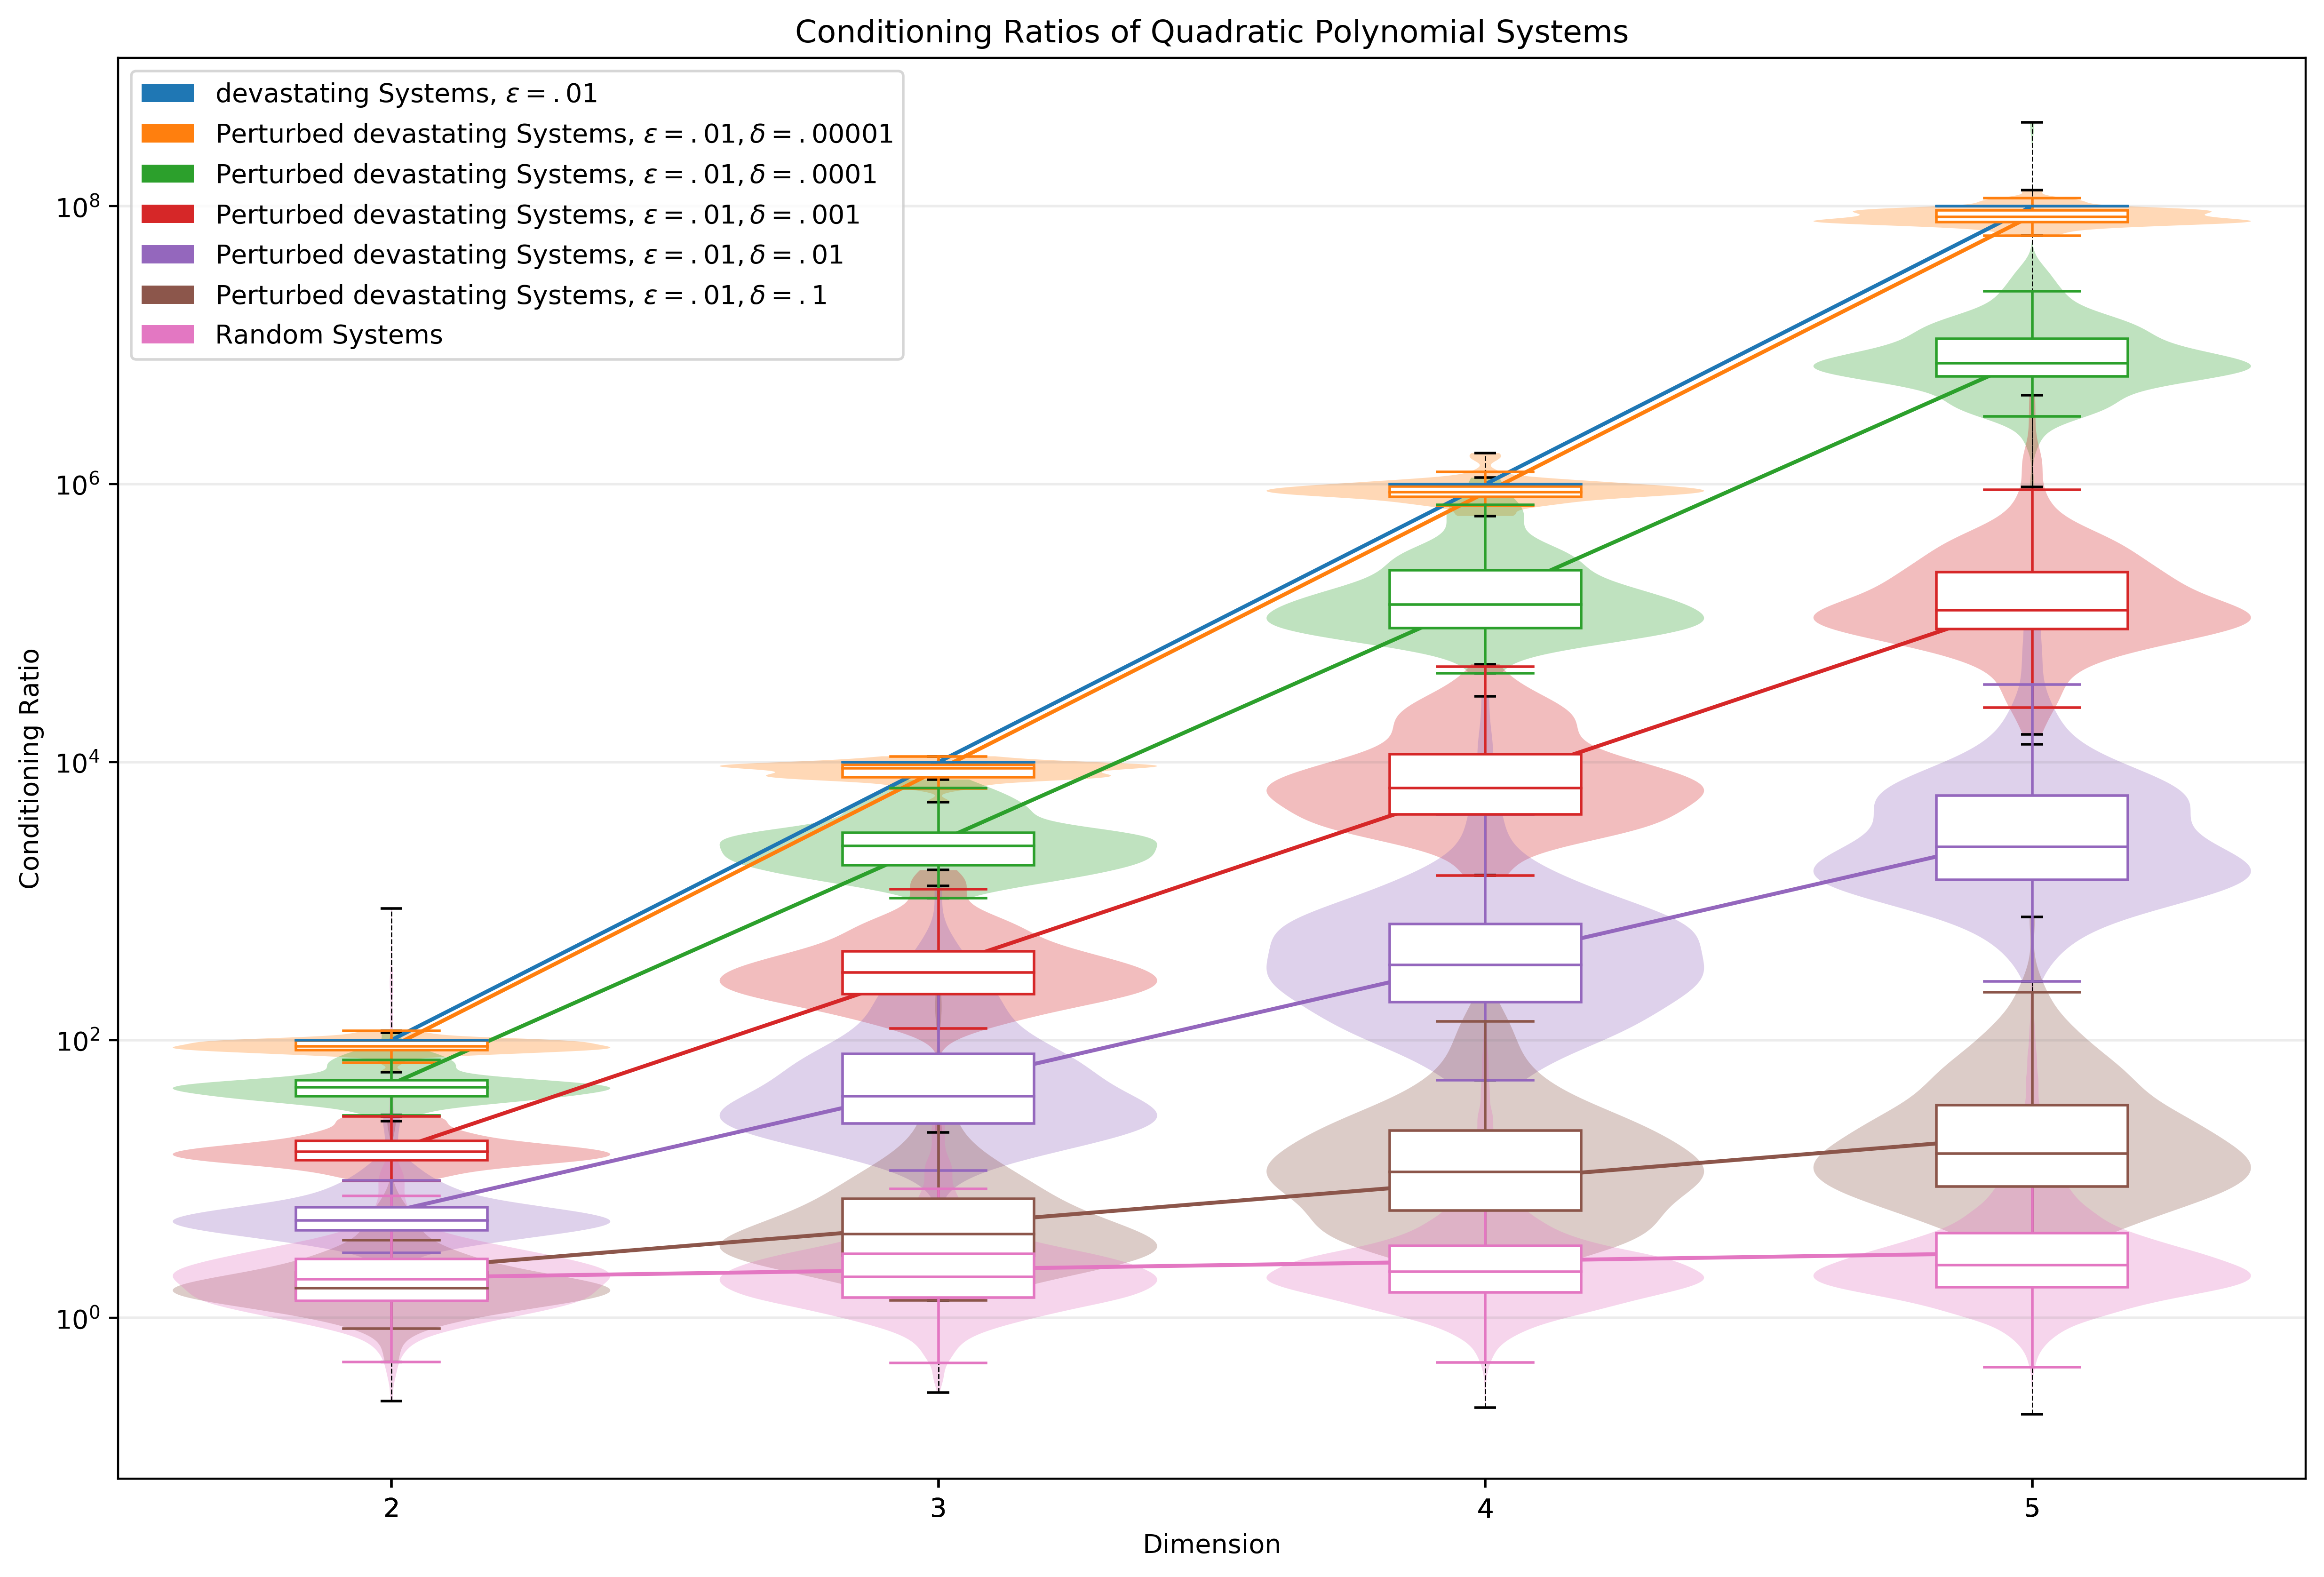

In [12]:
plot([dev_2,
      dev_2_delta_5,
      dev_2_delta_4,
      dev_2_delta_3,
      dev_2_delta_2,
      dev_2_delta_1,
      {d:rand_polished[d] for d in range(2,6)}],
     [r'devastating Systems, $\epsilon=.01$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.00001$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.0001$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.001$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.01$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.1$',
      r'Random Systems'],
     figsize=(15,10), filename='perturbed')

$\epsilon=10^{-2}$, $\delta=0$
Slope: 1.9999992674663203 
Intercept: -1.9999754282694306 
Exponential Growth Rate: 98.99983132802915

$\epsilon=10^{-2}$, $\delta=10^{-4}$
Slope: 1.7442352853374472 
Intercept: -1.8051239186420096 
Exponential Growth Rate: 54.49262708943212

$\epsilon=10^{-2}$, $\delta=10^{-3}$
Slope: 1.3208443661402682 
Intercept: -1.440407739258664 
Exponential Growth Rate: 19.933621437301504

$\epsilon=10^{-2}$, $\delta=10^{-2}$
Slope: 0.904524268145805 
Intercept: -1.044416834229024 
Exponential Growth Rate: 7.026464110761751



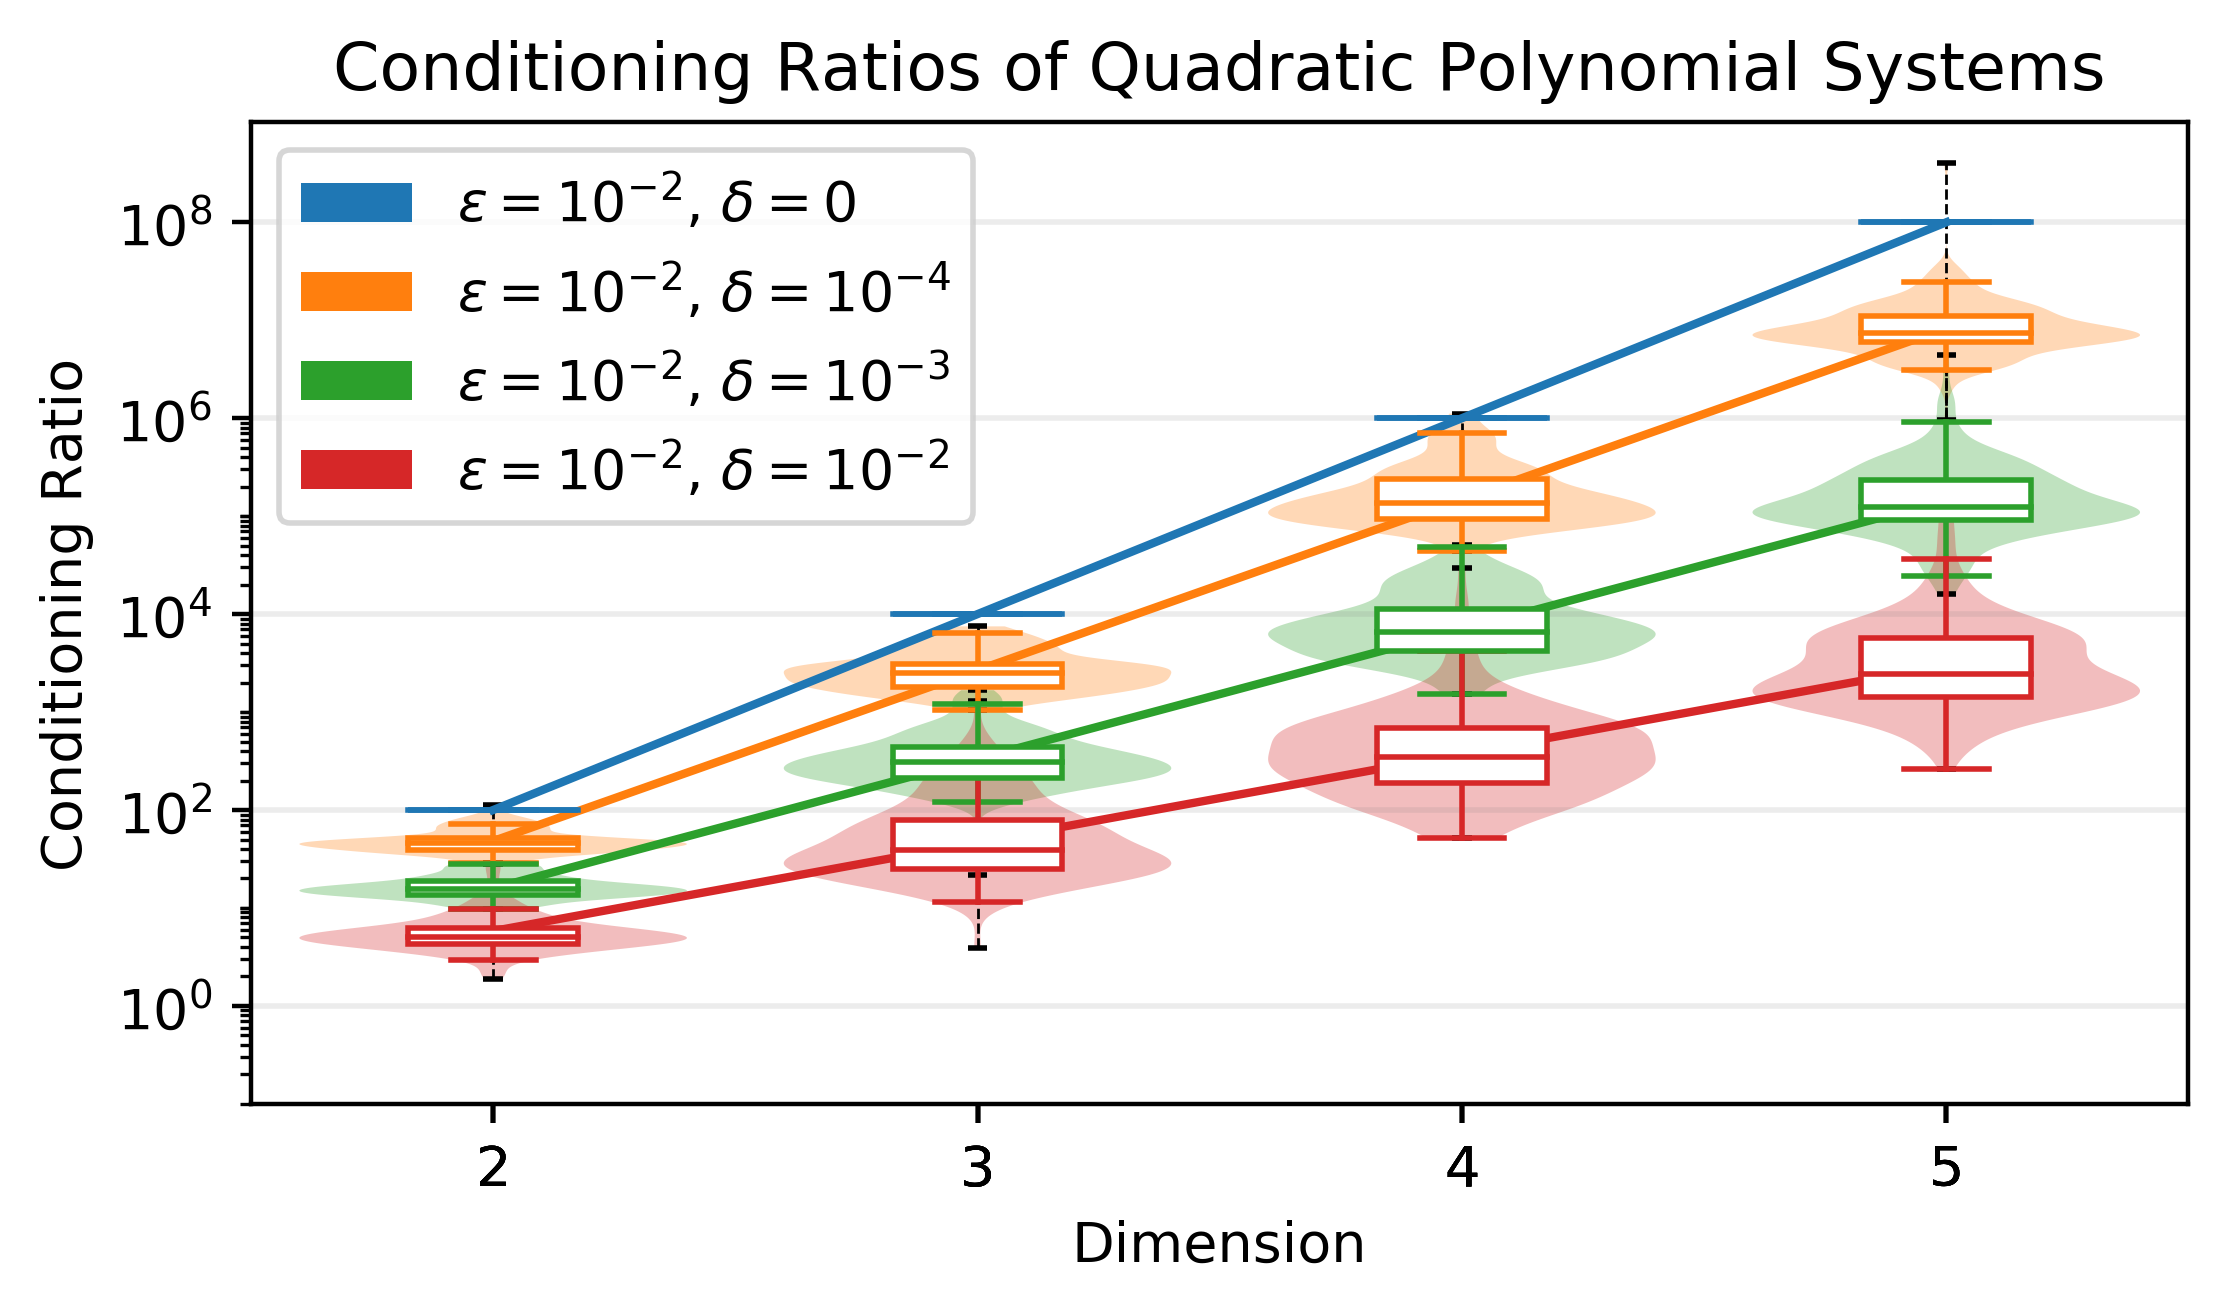

In [13]:
plot([dev_2,
      dev_2_delta_4,
      dev_2_delta_3,
      dev_2_delta_2],
     [r'$\epsilon=10^{-2}$, $\delta=0$',
      r'$\epsilon=10^{-2}$, $\delta=10^{-4}$',
      r'$\epsilon=10^{-2}$, $\delta=10^{-3}$',
      r'$\epsilon=10^{-2}$, $\delta=10^{-2}$'],
     figsize=(6.25,3.25), filename='perturbed_small', title='Conditioning Ratios of Quadratic Polynomial Systems',
     min_ylim=-1,
     max_ylim=6)

# How do the slopes of these lines decrease as you perturb more and more?

In [14]:
deltas,slopes = [],[]
for delta in np.logspace(-6,-1):
    print('delta =',delta,end='\r')
    data = devestating_conditioning_ratios([2,3,4,5],.01,
                                      'power',
                                      newton=False,
                                      save=False,
                                      delta=delta)
    data_log10 = [np.log10(data[d].flatten()) for d in data.keys()]
    points = np.array([[d,val] for i,d in enumerate(data.keys()) for val in data_log10[i]])
    slope = linregress(points)[0]
    deltas.append(delta)
    slopes.append(slope)

In [15]:
np.save('tests/conditioning_ratios/deltas.npy',deltas)
np.save('tests/conditioning_ratios/deltaslopes.npy',slope)

$\delta=0$
Slope: 1.9999992674663203 
Intercept: -1.9999754282694306 
Exponential Growth Rate: 98.99983132802915

$\delta=10^{-4}$
Slope: 1.7442352853374472 
Intercept: -1.8051239186420096 
Exponential Growth Rate: 54.49262708943212

$\delta=10^{-3}$
Slope: 1.3208443661402682 
Intercept: -1.440407739258664 
Exponential Growth Rate: 19.933621437301504

$\delta=10^{-2}$
Slope: 0.904524268145805 
Intercept: -1.044416834229024 
Exponential Growth Rate: 7.026464110761751

Unperturbed
Slope: 1.9999992674663203 
Intercept: -1.9999754282694306 
Exponential Growth Rate: 98.99983132802915

$\delta=10^{-4}$
Slope: 1.7442352853374472 
Intercept: -1.8051239186420096 
Exponential Growth Rate: 54.49262708943212

$\delta=10^{-3}$
Slope: 1.3208443661402682 
Intercept: -1.440407739258664 
Exponential Growth Rate: 19.933621437301504

$\delta=10^{-2}$
Slope: 0.904524268145805 
Intercept: -1.044416834229024 
Exponential Growth Rate: 7.026464110761751



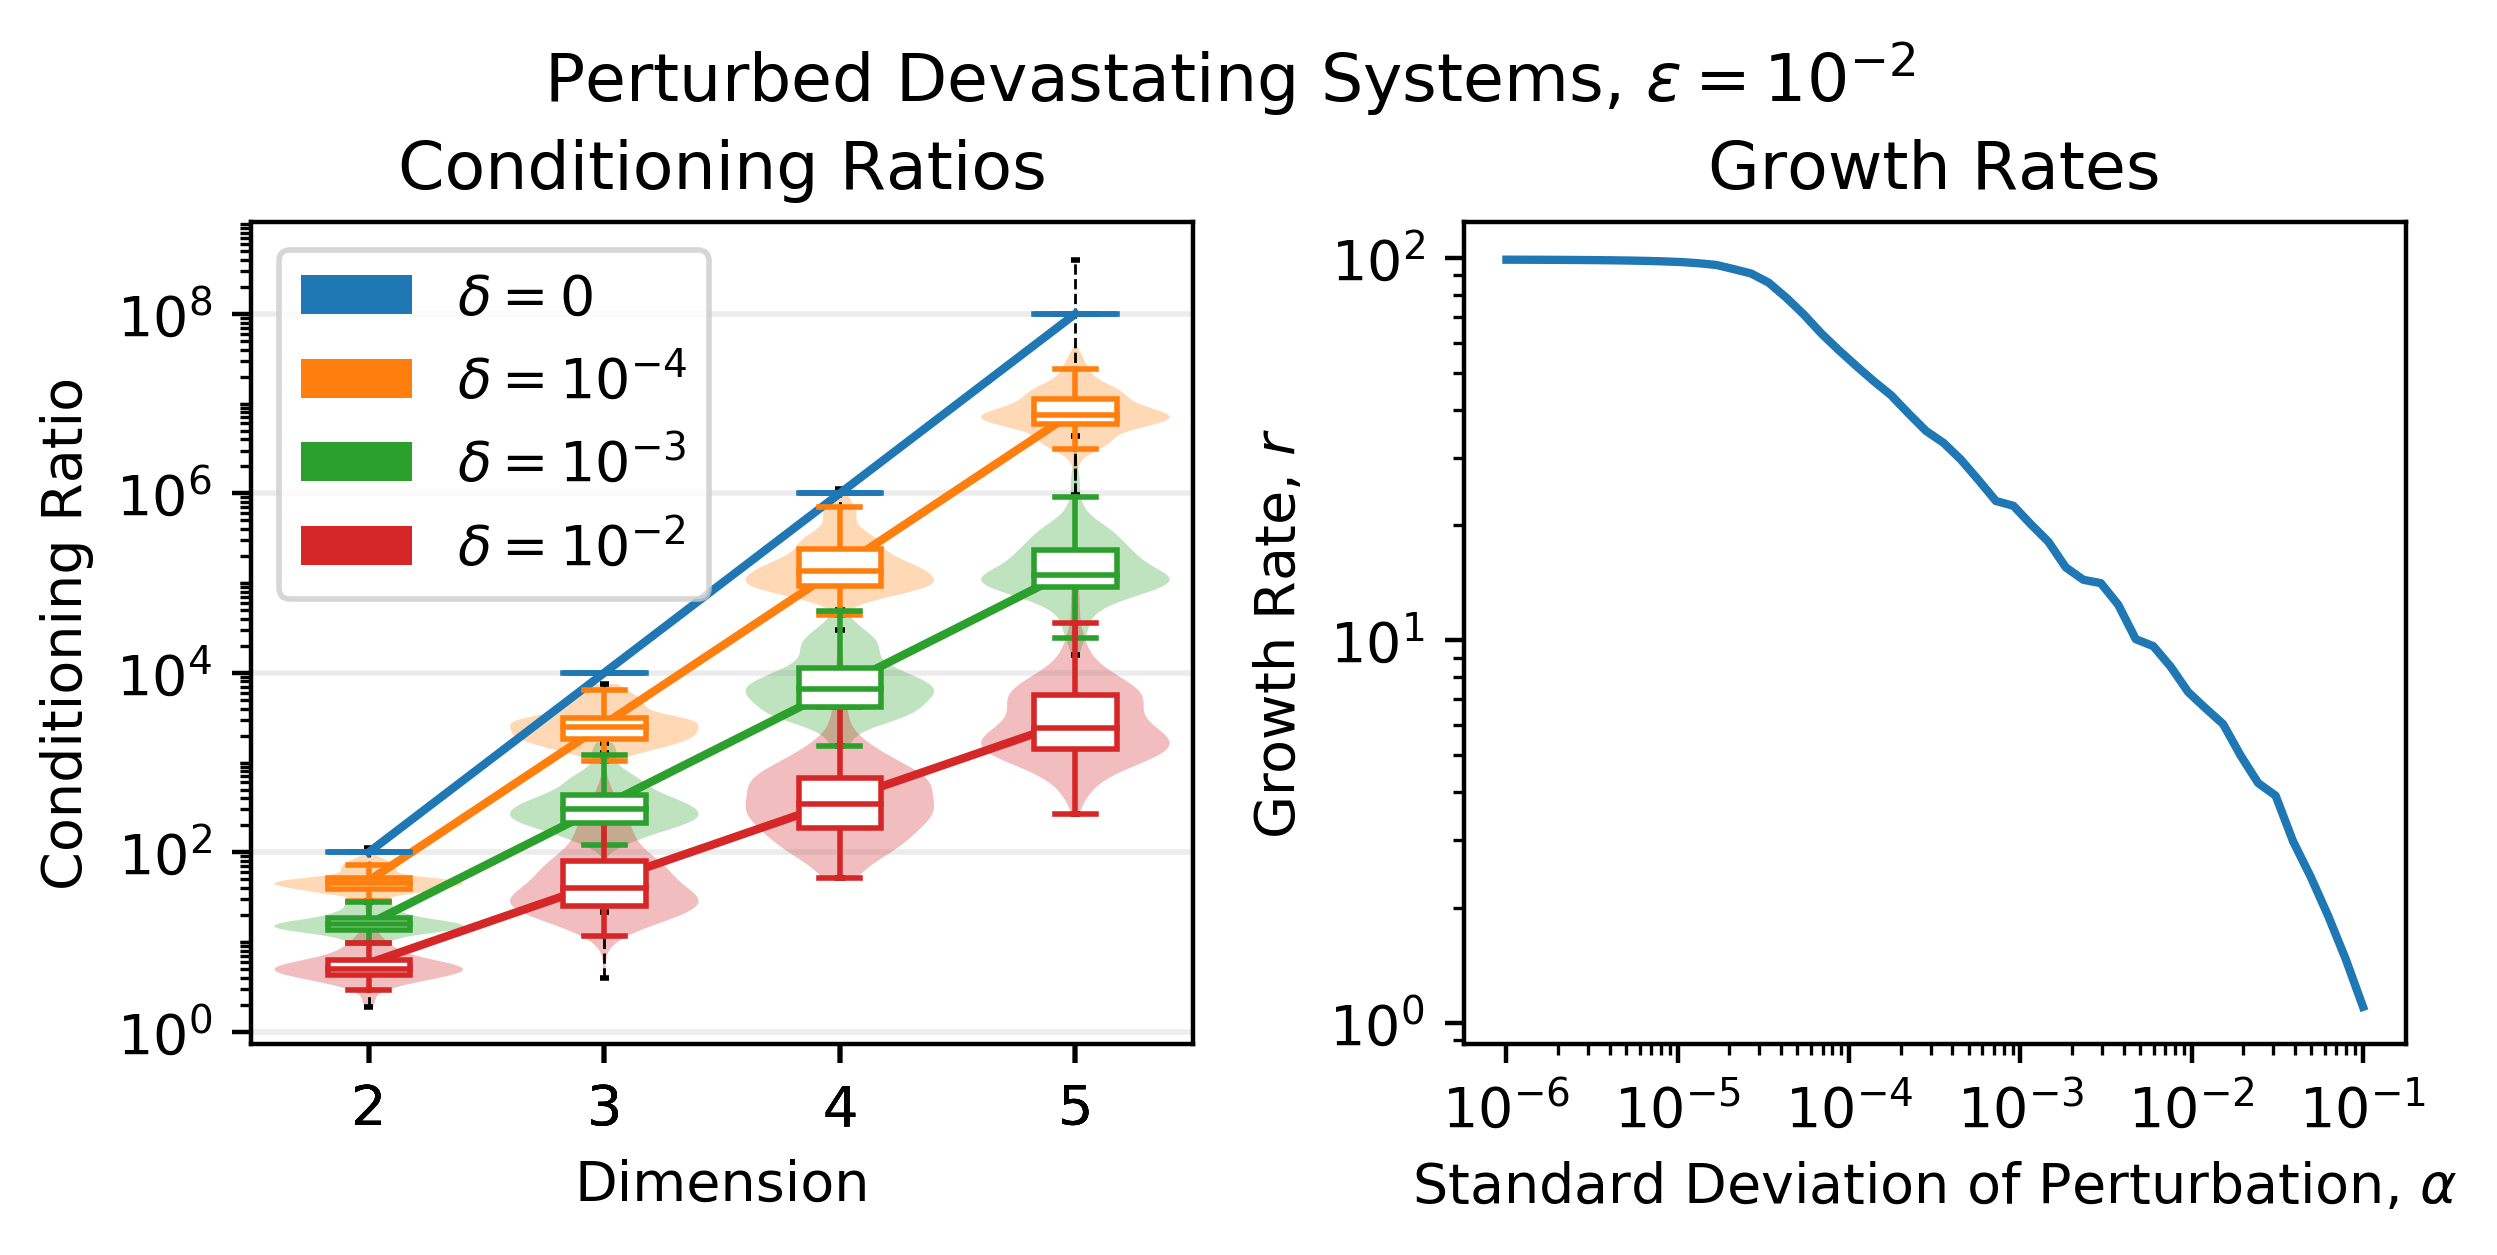

In [16]:
plot([[dev_2,
      dev_2_delta_4,
      dev_2_delta_3,
      dev_2_delta_2],
      [dev_2,
      dev_2_delta_4,
      dev_2_delta_3,
      dev_2_delta_2]],
     [[r'$\delta=0$',
      r'$\delta=10^{-4}$',
      r'$\delta=10^{-3}$',
      r'$\delta=10^{-2}$',],
      [r'Unperturbed',
      r'$\delta=10^{-4}$',
      r'$\delta=10^{-3}$',
      r'$\delta=10^{-2}$',]
      ],
     figsize=(6.25,3.25), filename='perturbed_small_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'Perturbed Devastating Systems, $\varepsilon=10^{-2}$'],
     subplots=[1,2], _2nd_plot=[deltas,10**np.array(slopes)-1],
     min_ylim=0,max_ylim=9)

summary: 

perturbing opens up new choices of basis

cond num probably isn't cont at zero

#### FIGURES IN THE PAPER:
* figsize is the desired actual size in the final printed article, measured in inches -- controlable
* dpi at least 300 -- defaults to 400
* file type  pdf -- does that in saving
* bbox_inches = ‘tight’ -- does that in saving

In [17]:
def get_log_medians(data):
    return [np.median(np.log10(data[d])) for d in data.keys()]
def get_perc_neg(data):
    return [np.mean(np.log10(data[d])<0)*100 for d in data.keys()]

In [18]:
print('log medians')
print('Rand:',np.round(get_log_medians(rand_polished),4))
print('Dev :',np.round(get_log_medians(dev_polished),4))
print('Rand % Negative:',np.round(get_perc_neg(rand_polished),4))

log medians
Rand: [0.2801 0.2958 0.3331 0.3817 0.4027 0.4176 0.452 ]
Dev : [1.0028 2.0018 3.0015 4.0021 5.0019 6.0012 7.0034]
Rand % Negative: [9.5833 9.096  6.9107 5.0902 4.2508 3.7985 3.8086]


# Generate Random Systems with known roots

Goal: Find $n$ hyperellipses that have common roots at  chosen points $\mathbf {r_1,\ldots,r_n}$. 

Let's just take this one hyperellipse at a time.

Pick a chosen center $\mathbf c$ of the hyperellipse.

Then the equation for the hyperellipse is

$$f(\mathbf x) = \sum_{j=1}^n \frac{(x_j - c_j)^2}{a_{j}^2} - 1$$

and it has a root at $\mathbf r_i$ iff

$$\sum_{j=1}^n \frac{(r_{ij} - c_j)^2}{a_{j}^2} = 1$$

Good news! This is just a linear system in $1/a_i^2$!

$$\begin{bmatrix}
(r_{11} - c_1)^2       &   (r_{11} - c_2)^2       & \dots     &   (r_{1n} - c_n)^2       \\
(r_{21} - c_1)^2       &   (r_{21} - c_2)^2       & \dots     &   (r_{2n} - c_n)^2       \\
\vdots  &  \vdots   &   \vdots  &   \vdots  \\   
(r_{n1} - c_1)^2       &   (r_{n1} - c_2)^2       & \dots     &   (r_{nn} - c_n)^2       \\
\end{bmatrix}
\begin{bmatrix}
1/a_1^2    \\
1/a_2^2     \\
\vdots  \\
1/a_n^2     \\
\end{bmatrix}=
\mathbb 1$$

If you get a solution that has some negative outputs for $1/a_i^2$, then you've got some sort of cross between a hyperellipse and a hyperhyperbola.

For convenience, we're just going to use $1/a_i^2$ for our coefficients and not actually convert to $a_i$. In the code, I've denoted the $\mathbf a$ vector as `scalar`.

If we repeat this process $n$ times, we end up with $n$ hyper-conics that have common roots at $\mathbf {r_1,\ldots,r_n}$.

In [79]:
np.random.seed(0)
dim = 2
roots = np.random.randn(dim,dim)
centers = np.random.randn(dim,dim)
print('Chosen Roots:',*roots)
print('Chosen Centers:',*centers)

Chosen Roots: [1.76405235 0.40015721] [0.97873798 2.2408932 ]
Chosen Centers: [ 1.86755799 -0.97727788] [ 0.95008842 -0.15135721]


In [80]:
mp.matrix([[coord for coord in root] for root in roots])

matrix(
[['1.76405234596766', '0.400157208367223'],
 ['0.978737984105739', '2.24089319920146']])

In [81]:
scalars = [get_scalar(c,roots) for c in centers]
print('Scalars:',*scalars)

Scalars: [-6.09487717  0.56147239] [1.42922176 0.17453276]


In [82]:
polys = [get_MultiPower(c,roots) for c in centers]
print('Coefficients of Polynomials:',*[p.coeff for p in polys],sep='\n')

Coefficients of Polynomials:
[[-21.72130051   1.0974291    0.56147239]
 [ 22.76507313   0.           0.        ]
 [ -6.09487717   0.           0.        ]]
[[ 0.29411112  0.05283358  0.17453276]
 [-2.71577408  0.          0.        ]
 [ 1.42922176  0.          0.        ]]


In [173]:
mp.mp.dps = 15
print(mp.mp)

Mpmath settings:
  mp.prec = 53                [default: 53]
  mp.dps = 15                 [default: 15]
  mp.trap_complex = False     [default: False]


In [193]:
%timeit qrtroots = er.solve(polys,method='qrt')
qrtroots = er.solve(polys,method='qrt')
mp.chop(qrtroots)

60.3 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


matrix(
[['0.97873798410574', '2.24089319920146'],
 ['1.76405234596766', '0.400157208367224'],
 [mpc(real='1.5747047340267419', imag='0.40344221914591383'), mpc(real='-2.333524420165737', imag='0.945647563662532')],
 [mpc(real='1.5747047340267408', imag='-0.40344221914591288'), mpc(real='-2.333524420165733', imag='-0.94564756366253389')]])

In [194]:
%timeit svdroots = er.solve(polys,method='svd')
svdroots = er.solve(polys,method='svd')
mp.chop(svdroots)

63.2 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


matrix(
[['0.978737984105738', '2.24089319920146'],
 ['1.76405234596766', '0.400157208367228'],
 [mpc(real='1.5747047340267402', imag='0.40344221914591905'), mpc(real='-2.3335244201657295', imag='0.94564756366252212')],
 [mpc(real='1.5747047340267413', imag='-0.40344221914591599'), mpc(real='-2.3335244201657335', imag='-0.94564756366252323')]])

In [197]:
mp.mp.dps = 100
print(mp.mp)

Mpmath settings:
  mp.prec = 336               [default: 53]
  mp.dps = 100                [default: 15]
  mp.trap_complex = False     [default: False]


In [198]:
%timeit qrtroots = er.solve(polys,method='qrt')
qrtroots = er.solve(polys,method='qrt')
mp.chop(qrtroots)

83.4 ms ± 8.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


matrix(
[['0.9787379841057389719344720509850751486916180939416333641144706321457115146753230638698702093929448325', '2.24089319920145979878049386950567842585959800337703720257176982184554800521526736159223064909481338'],
 ['1.764052345967664078135149857742593765346016860784531727569291684943166831993121247579132865394286246', '0.400157208367224295237519288511061435304759704876116740081099748859385616214113080277115645463113348'],
 [mpc(real='1.574704734026741203135549316038578732973192102737274122712670818907129476576308395625976328779496168104', imag='0.4034422191459161768987320758241354606845880809047754944662943310306391148741092558305786577377026250882'), mpc(real='-2.333524420165733360313941074097688718764552351978701358530900858056313636286104860144225857841400660485', imag='0.9456475636625263146471000265375034781720746598729871619587172250914726320497643757291247056590669313699')],
 [mpc(real='1.574704734026741203135549316038578732973192102737274122712670818907129476576308395625

In [199]:
%timeit svdroots = er.solve(polys,method='svd')
svdroots = er.solve(polys,method='svd')
mp.chop(svdroots)

98.5 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


matrix(
[['0.9787379841057389719344720509850751486916180939416333641144706321457115146753230638698702093929448325', '2.24089319920145979878049386950567842585959800337703720257176982184554800521526736159223064909481338'],
 ['1.764052345967664078135149857742593765346016860784531727569291684943166831993121247579132865394286246', '0.4001572083672242952375192885110614353047597048761167400810997488593856162141130802771156454631133478'],
 [mpc(real='1.574704734026741203135549316038578732973192102737274122712670818907129476576308395625976328779496168118', imag='0.403442219145916176898732075824135460684588080904775494466294331030639114874109255830578657737702625099'), mpc(real='-2.333524420165733360313941074097688718764552351978701358530900858056313636286104860144225857841400660056', imag='0.945647563662526314647100026537503478172074659872987161958717225091472632049764375729124705659066930977')],
 [mpc(real='1.5747047340267412031355493160385787329731921027372741227126708189071294765763083956259

# Generate Random Systems that Almost have Multiple Roots

### roots of multiplicity dim

In [188]:
np.logspace(-6,-1)

array([1.00000000e-06, 1.26485522e-06, 1.59985872e-06, 2.02358965e-06,
       2.55954792e-06, 3.23745754e-06, 4.09491506e-06, 5.17947468e-06,
       6.55128557e-06, 8.28642773e-06, 1.04811313e-05, 1.32571137e-05,
       1.67683294e-05, 2.12095089e-05, 2.68269580e-05, 3.39322177e-05,
       4.29193426e-05, 5.42867544e-05, 6.86648845e-05, 8.68511374e-05,
       1.09854114e-04, 1.38949549e-04, 1.75751062e-04, 2.22299648e-04,
       2.81176870e-04, 3.55648031e-04, 4.49843267e-04, 5.68986603e-04,
       7.19685673e-04, 9.10298178e-04, 1.15139540e-03, 1.45634848e-03,
       1.84206997e-03, 2.32995181e-03, 2.94705170e-03, 3.72759372e-03,
       4.71486636e-03, 5.96362332e-03, 7.54312006e-03, 9.54095476e-03,
       1.20679264e-02, 1.52641797e-02, 1.93069773e-02, 2.44205309e-02,
       3.08884360e-02, 3.90693994e-02, 4.94171336e-02, 6.25055193e-02,
       7.90604321e-02, 1.00000000e-01])

In [169]:
ls tests/conditioning_ratios/nearby_roots/mult

1e-6.txt                               alpha1e-05_2testsperdim_rootconds.npy
1e-6err.txt                            alpha1e-06_2testsperdim.npy
alpha1e-05_2testsperdim.npy            alpha1e-06_2testsperdim_eigconds.npy
alpha1e-05_2testsperdim_eigconds.npy   alpha1e-06_2testsperdim_rootconds.npy


In [200]:
folder = 'tests/conditioning_ratios/nearby_roots/mult/'
ratios = np.load(folder+'alpha1e-05_2testsperdim_100digitsprecision.npy',allow_pickle=True)
rootconds = np.load(folder+'alpha1e-05_2testsperdim_100digitsprecision_rootconds.npy',
                    allow_pickle=True)
eigconds = np.load(folder+'alpha1e-05_2testsperdim_100digitsprecision_eigconds.npy',allow_pickle=True)

In [201]:
ratios

array({2: array([2.87013590e-05, 2.53725031e-05, 1.16506882e-05, 3.90152439e-06]), 3: array([6.28151742e-06, 7.12759555e-06, 5.13183021e-06, 1.46279868e-07,
       1.95864936e-07, 1.32707553e-07]), 4: array([4.07818340e-06, 3.17289095e-06, 2.57257988e-06, 2.26486367e-06,
       7.95640183e-07, 6.74479709e-07, 9.41910697e-07, 8.26812592e-07])},
      dtype=object)

In [202]:
rootconds

array({2: array([147497.99047373, 625361.74539787]), 3: array([  305119.43623756, 10333011.22620453]), 4: array([1242110.01061432, 2802559.63197401])},
      dtype=object)

In [203]:
eigconds

array({2: array([4.23339277, 3.74239322, 7.28589472, 2.4398641 ]), 3: array([1.91661305, 2.17476794, 1.56582114, 1.51151152, 2.02387458,
       1.37126863]), 4: array([5.06555242, 3.94107961, 3.19542722, 2.81320984, 2.22982906,
       1.89026961, 2.6397609 , 2.31719159])}, dtype=object)

In [113]:
mp.mp.dps = 100
print(mp.mp)

Mpmath settings:
  mp.prec = 336               [default: 53]
  mp.dps = 100                [default: 15]
  mp.trap_complex = False     [default: False]


In [118]:
%%time 
mult1,eigconds1,rootconds1 = get_data(alpha=.1,
                                            gen_func=gen_almost_multiple_roots, 
                                            detailed=True, 
                                            save=True,
                                            seeds = {2:range(1),3:range(1),4:range(1)})

2
3
4
CPU times: user 1min 1s, sys: 534 ms, total: 1min 1s
Wall time: 1min 6s


In [197]:
'1.00000000e-06 1.26485522e-06 1.59985872e-06 2.02358965e-06 2.55954792e-06 3.23745754e-06 4.09491506e-06 5.17947468e-06 6.55128557e-06 8.28642773e-06 1.04811313e-05 1.32571137e-05 1.67683294e-05 2.12095089e-05 2.68269580e-05 3.39322177e-05 4.29193426e-05 5.42867544e-05 6.86648845e-05 8.68511374e-05 1.09854114e-04 1.38949549e-04 1.75751062e-04 2.22299648e-04 2.81176870e-04 3.55648031e-04 4.49843267e-04 5.68986603e-04 7.19685673e-04 9.10298178e-04 1.15139540e-03 1.45634848e-03 1.84206997e-03 2.32995181e-03 2.94705170e-03 3.72759372e-03 4.71486636e-03 5.96362332e-03 7.54312006e-03 9.54095476e-03 1.20679264e-02 1.52641797e-02 1.93069773e-02 2.44205309e-02 3.08884360e-02 3.90693994e-02 4.94171336e-02 6.25055193e-02 7.90604321e-02 1.00000000e-01 1e-5 1e-4 1e-3 1e-2'.split(' ')

['1.00000000e-06',
 '1.26485522e-06',
 '1.59985872e-06',
 '2.02358965e-06',
 '2.55954792e-06',
 '3.23745754e-06',
 '4.09491506e-06',
 '5.17947468e-06',
 '6.55128557e-06',
 '8.28642773e-06',
 '1.04811313e-05',
 '1.32571137e-05',
 '1.67683294e-05',
 '2.12095089e-05',
 '2.68269580e-05',
 '3.39322177e-05',
 '4.29193426e-05',
 '5.42867544e-05',
 '6.86648845e-05',
 '8.68511374e-05',
 '1.09854114e-04',
 '1.38949549e-04',
 '1.75751062e-04',
 '2.22299648e-04',
 '2.81176870e-04',
 '3.55648031e-04',
 '4.49843267e-04',
 '5.68986603e-04',
 '7.19685673e-04',
 '9.10298178e-04',
 '1.15139540e-03',
 '1.45634848e-03',
 '1.84206997e-03',
 '2.32995181e-03',
 '2.94705170e-03',
 '3.72759372e-03',
 '4.71486636e-03',
 '5.96362332e-03',
 '7.54312006e-03',
 '9.54095476e-03',
 '1.20679264e-02',
 '1.52641797e-02',
 '1.93069773e-02',
 '2.44205309e-02',
 '3.08884360e-02',
 '3.90693994e-02',
 '4.94171336e-02',
 '6.25055193e-02',
 '7.90604321e-02',
 '1.00000000e-01',
 '1e-5',
 '1e-4',
 '1e-3',
 '1e-2']

In [198]:
len(_)

54

In [119]:
np.logspace(-6,-1)

array([1.00000000e-06, 1.26485522e-06, 1.59985872e-06, 2.02358965e-06,
       2.55954792e-06, 3.23745754e-06, 4.09491506e-06, 5.17947468e-06,
       6.55128557e-06, 8.28642773e-06, 1.04811313e-05, 1.32571137e-05,
       1.67683294e-05, 2.12095089e-05, 2.68269580e-05, 3.39322177e-05,
       4.29193426e-05, 5.42867544e-05, 6.86648845e-05, 8.68511374e-05,
       1.09854114e-04, 1.38949549e-04, 1.75751062e-04, 2.22299648e-04,
       2.81176870e-04, 3.55648031e-04, 4.49843267e-04, 5.68986603e-04,
       7.19685673e-04, 9.10298178e-04, 1.15139540e-03, 1.45634848e-03,
       1.84206997e-03, 2.32995181e-03, 2.94705170e-03, 3.72759372e-03,
       4.71486636e-03, 5.96362332e-03, 7.54312006e-03, 9.54095476e-03,
       1.20679264e-02, 1.52641797e-02, 1.93069773e-02, 2.44205309e-02,
       3.08884360e-02, 3.90693994e-02, 4.94171336e-02, 6.25055193e-02,
       7.90604321e-02, 1.00000000e-01])

In [199]:
num_alphas = 54
seconds = 75
num_tests_per_dim = 100
for num_cores in range(1,30):
    print(f'{num_cores} \tcores:\t',np.ceil(num_alphas/num_cores)*seconds*num_tests_per_dim/60/60, 'hours\t',num_alphas/num_cores*seconds*num_tests_per_dim/60, 'minutes')

1 	cores:	 112.5 hours	 6750.0 minutes
2 	cores:	 56.25 hours	 3375.0 minutes
3 	cores:	 37.5 hours	 2250.0 minutes
4 	cores:	 29.166666666666668 hours	 1687.5 minutes
5 	cores:	 22.916666666666668 hours	 1350.0 minutes
6 	cores:	 18.75 hours	 1125.0 minutes
7 	cores:	 16.666666666666668 hours	 964.2857142857142 minutes
8 	cores:	 14.583333333333334 hours	 843.75 minutes
9 	cores:	 12.5 hours	 750.0 minutes
10 	cores:	 12.5 hours	 675.0 minutes
11 	cores:	 10.416666666666666 hours	 613.6363636363636 minutes
12 	cores:	 10.416666666666666 hours	 562.5 minutes
13 	cores:	 10.416666666666666 hours	 519.2307692307693 minutes
14 	cores:	 8.333333333333334 hours	 482.1428571428571 minutes
15 	cores:	 8.333333333333334 hours	 450.0 minutes
16 	cores:	 8.333333333333334 hours	 421.875 minutes
17 	cores:	 8.333333333333334 hours	 397.0588235294117 minutes
18 	cores:	 6.25 hours	 375.0 minutes
19 	cores:	 6.25 hours	 355.2631578947368 minutes
20 	cores:	 6.25 hours	 337.5 minutes
21 	cores:	 6.2

In [ ]:
mult2,eigconds2,rootconds2 = get_data(alpha=.01,gen_func=gen_almost_multiple_roots, detailed=True)

In [ ]:
mult3,eigconds3,rootconds3 = get_data(alpha=.001,gen_func=gen_almost_multiple_roots, detailed=True)

In [ ]:
mult4,eigconds4,rootconds4 = get_data(alpha=.0001,gen_func=gen_almost_multiple_roots, detailed=True)

In [ ]:
mult5,eigconds5,rootconds5 = get_data(alpha=.00001,gen_func=gen_almost_multiple_roots, detailed=True)

In [ ]:
mult6,eigconds6,rootconds6 = get_data(alpha=.000001,gen_func=gen_almost_multiple_roots, detailed=True)

$\alpha=10^{-6}$
Slope: 0.4479311264310323 
Intercept: 5.57890653673452 
Exponential Growth Rate: 1.8049887672133647

$\alpha=10^{-5}$
Slope: 0.4467208781188835 
Intercept: 4.5845748726134765 
Exponential Growth Rate: 1.7971829870286848

$\alpha=10^{-4}$
Slope: 0.4483146169329381 
Intercept: 3.5806829095559047 
Exponential Growth Rate: 1.807466720908263

$\alpha=10^{-3}$
Slope: 0.4436661314805303 
Intercept: 2.5908737706378338 
Exponential Growth Rate: 1.777577154693681

$\alpha=10^{-2}$
Slope: 0.4459462368300157 
Intercept: 1.5858215909516378 
Exponential Growth Rate: 1.7921981616975904

$\alpha=10^{-1}$
Slope: 0.43264279672049993 
Intercept: 0.6151669469582972 
Exponential Growth Rate: 1.7079634402695398



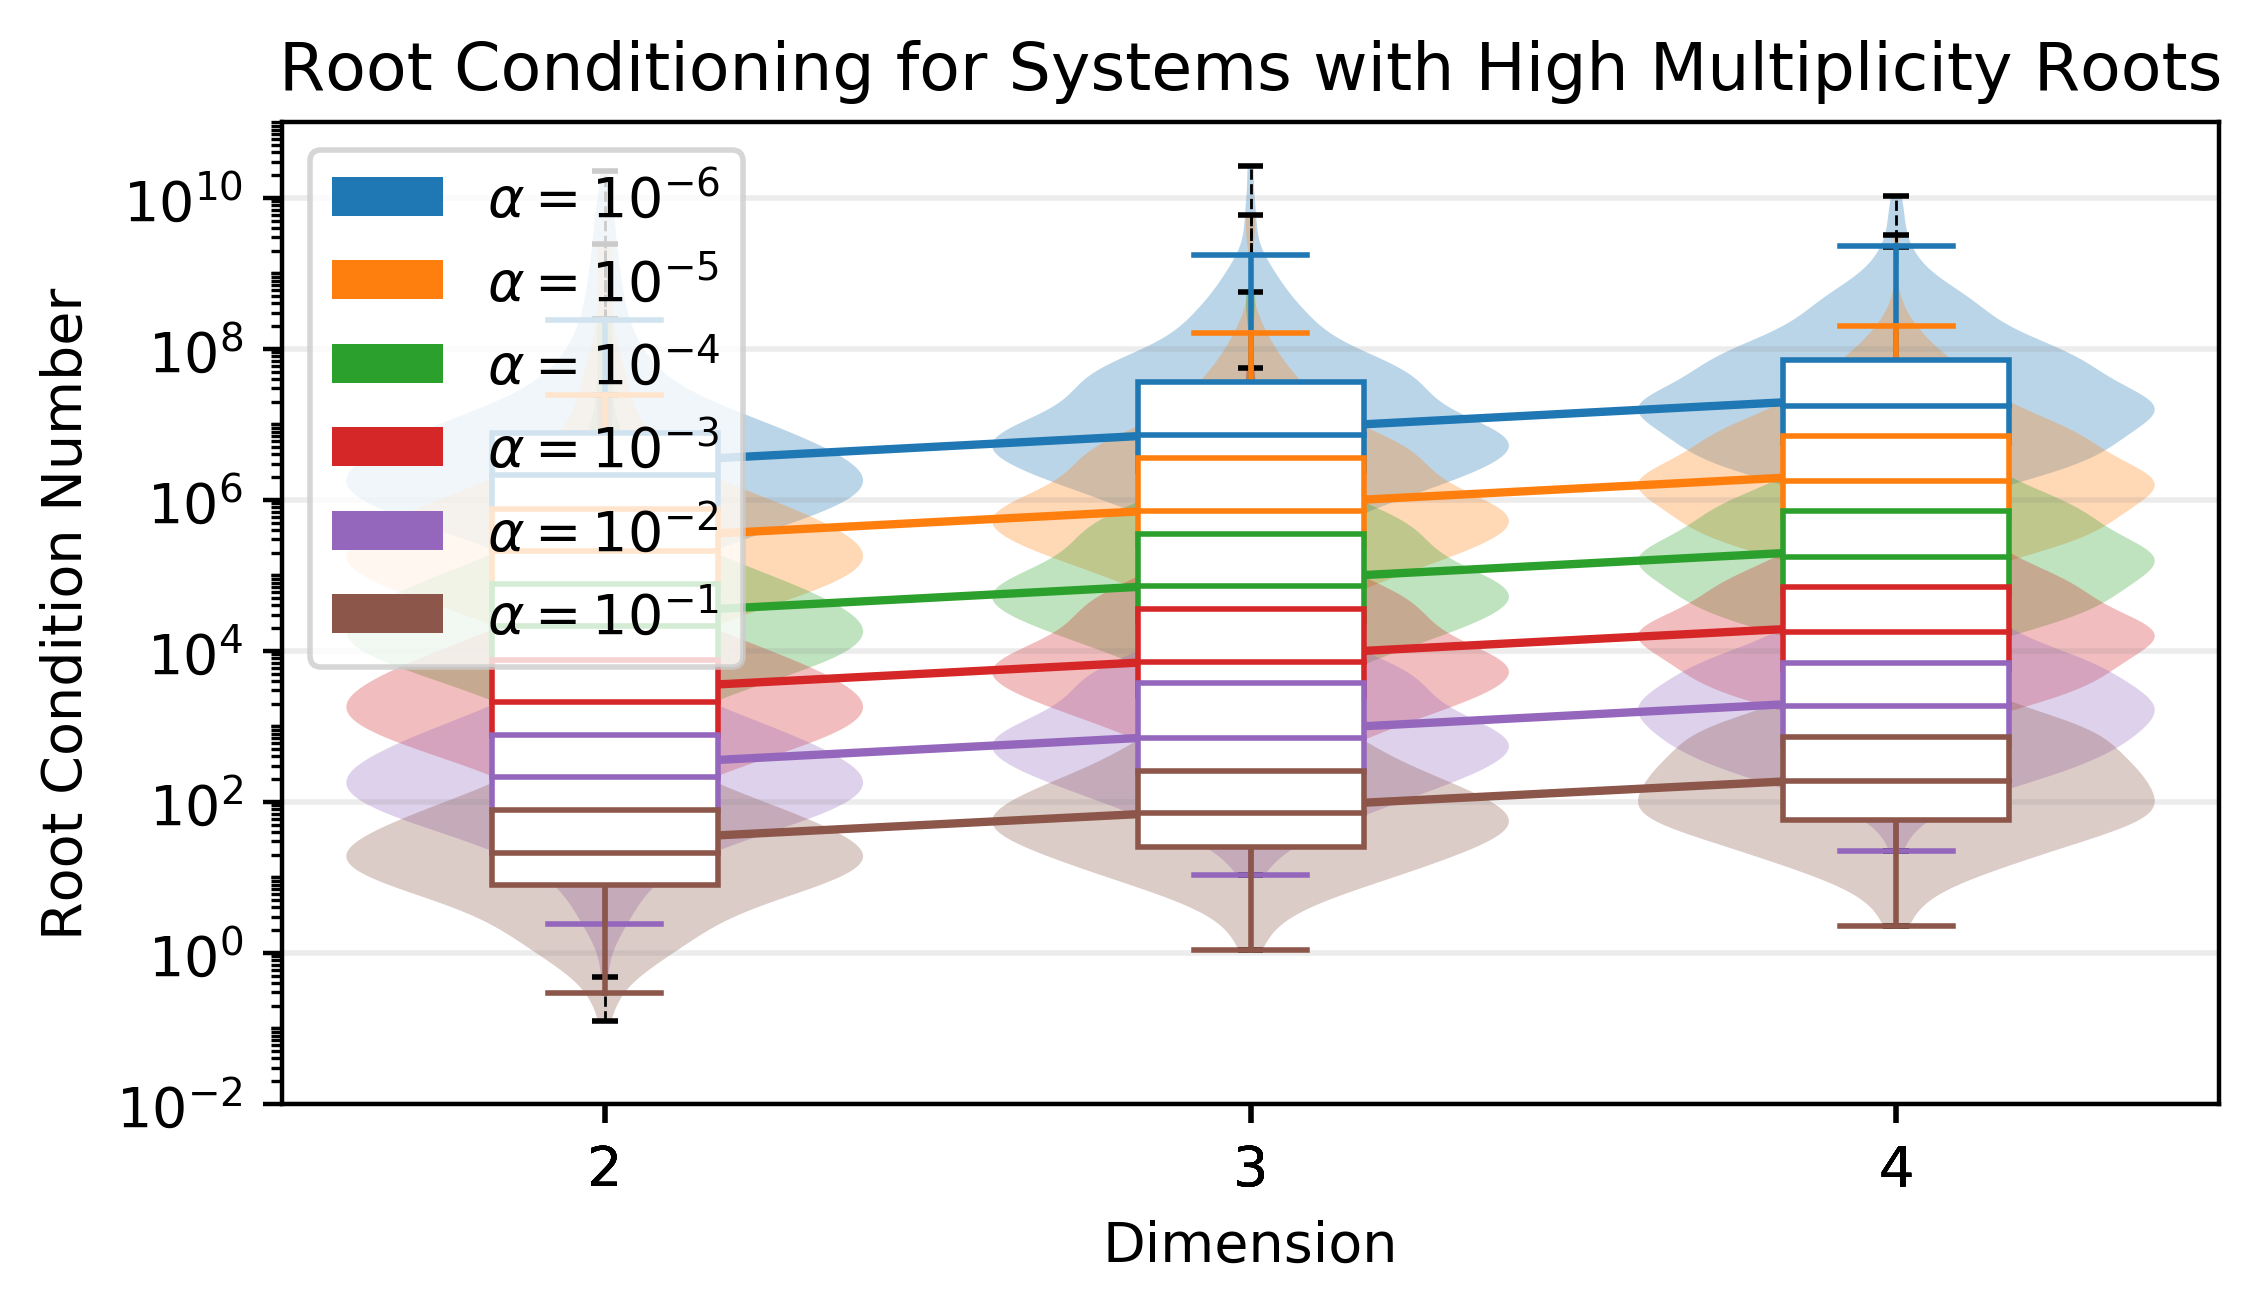

In [38]:
plot([rootconds6,
      rootconds5,
      rootconds4,
      rootconds3,
      rootconds2,
      rootconds1],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-5}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
     figsize=(6.25,3.25), 
     filename='high_multiplicity_root_conds', 
     title='Root Conditioning for Systems with High Multiplicity Roots',
     yaxislabel='Root Condition Number',
     min_ylim=-2,
     max_ylim=11)

$\alpha=10^{-6}$
Slope: 1.4225044006077738 
Intercept: 3.5284836306371403 
Exponential Growth Rate: 25.45479500633772

$\alpha=10^{-5}$
Slope: 1.525979096564605 
Intercept: 3.299887278638807 
Exponential Growth Rate: 32.57214549295682

$\alpha=10^{-4}$
Slope: 2.1673524598350524 
Intercept: 0.9630887175989749 
Exponential Growth Rate: 146.0118896205113

$\alpha=10^{-3}$
Slope: 2.910797553707557 
Intercept: -2.2336069332787725 
Exponential Growth Rate: 813.3245982715696

$\alpha=10^{-2}$
Slope: 2.075314253488284 
Intercept: -1.6260394145091448 
Exponential Growth Rate: 117.93625333979418

$\alpha=10^{-1}$
Slope: 1.1226803817384683 
Intercept: -0.7422009331042938 
Exponential Growth Rate: 12.264179234922832



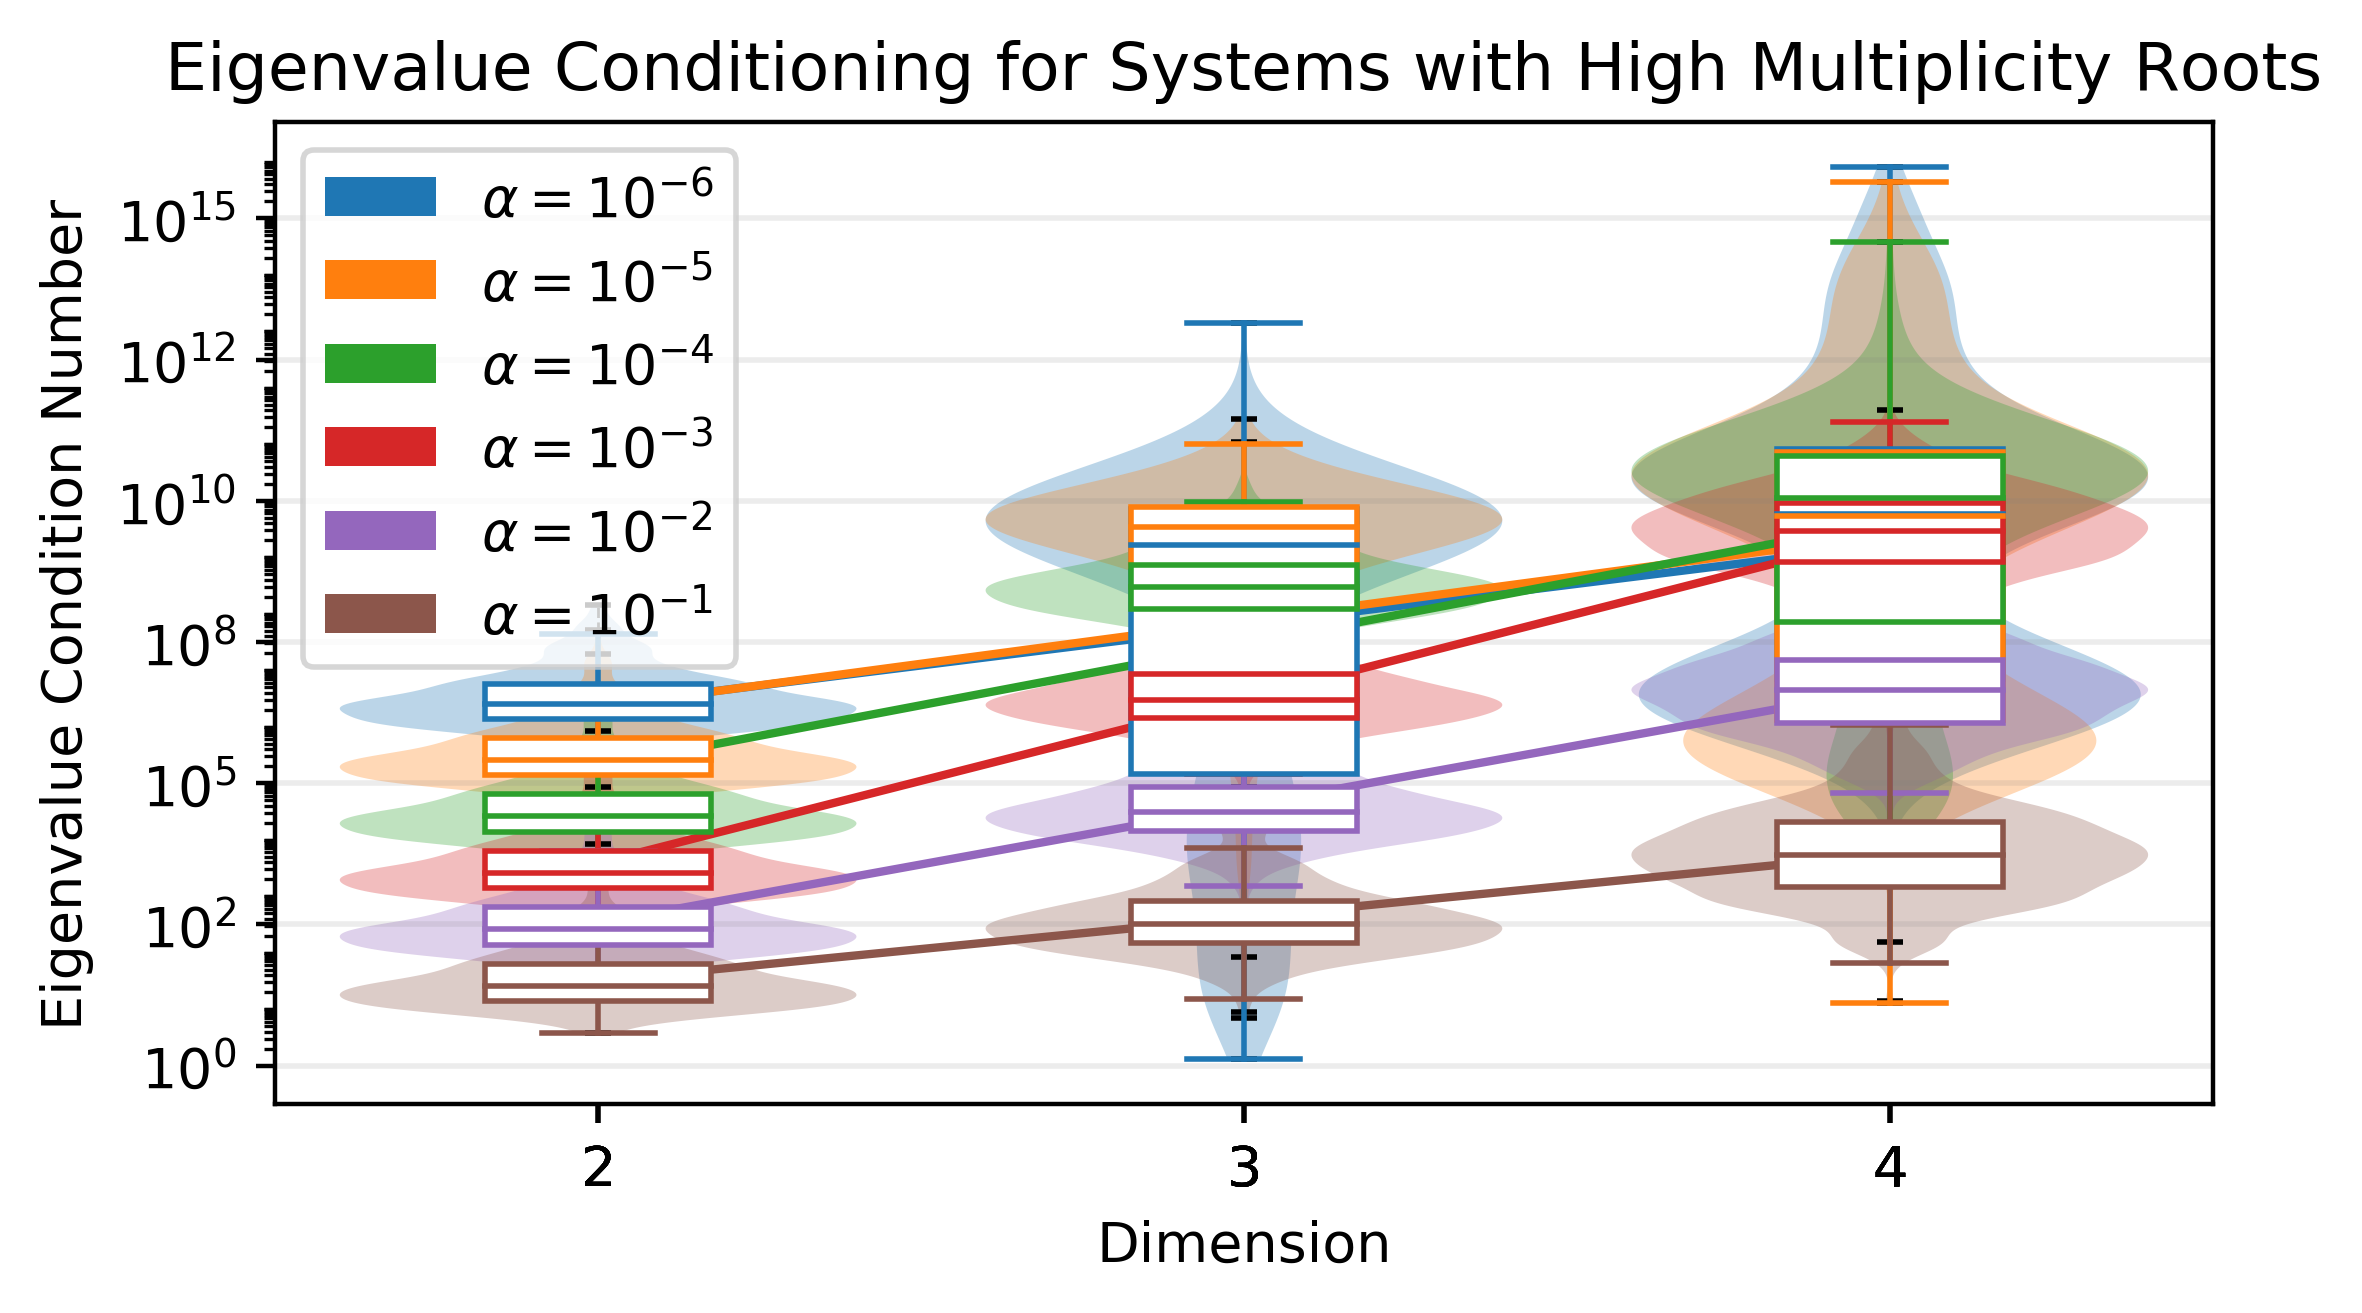

In [40]:
plot([eigconds6,
      eigconds5,
      eigconds4,
      eigconds3,
      eigconds2,
      eigconds1],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-5}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
     figsize=(6.25,3.25), 
     filename='high_multiplicity_eig_conds', 
     title='Eigenvalue Conditioning for Systems with High Multiplicity Roots',
     yaxislabel='Eigenvalue Condition Number',
     min_ylim=0,
     max_ylim=16)

$\alpha=10^{-6}$
Slope: 0.9857371169531469 
Intercept: -2.0863952883769077 
Exponential Growth Rate: 8.676919247788993

$\alpha=10^{-5}$
Slope: 1.0906662394629774 
Intercept: -1.3214467728080503 
Exponential Growth Rate: 11.321575413706915

$\alpha=10^{-4}$
Slope: 1.730204741283626 
Intercept: -2.653576420075135 
Exponential Growth Rate: 52.728503122746936

$\alpha=10^{-3}$
Slope: 2.478646441932547 
Intercept: -4.86158465630106 
Exponential Growth Rate: 300.0554141578218

$\alpha=10^{-2}$
Slope: 1.6411530646972594 
Intercept: -3.249835049141977 
Exponential Growth Rate: 42.76763345906044

$\alpha=10^{-1}$
Slope: 0.6996369129914483 
Intercept: -1.3882990479771373 
Exponential Growth Rate: 4.0076839679360265



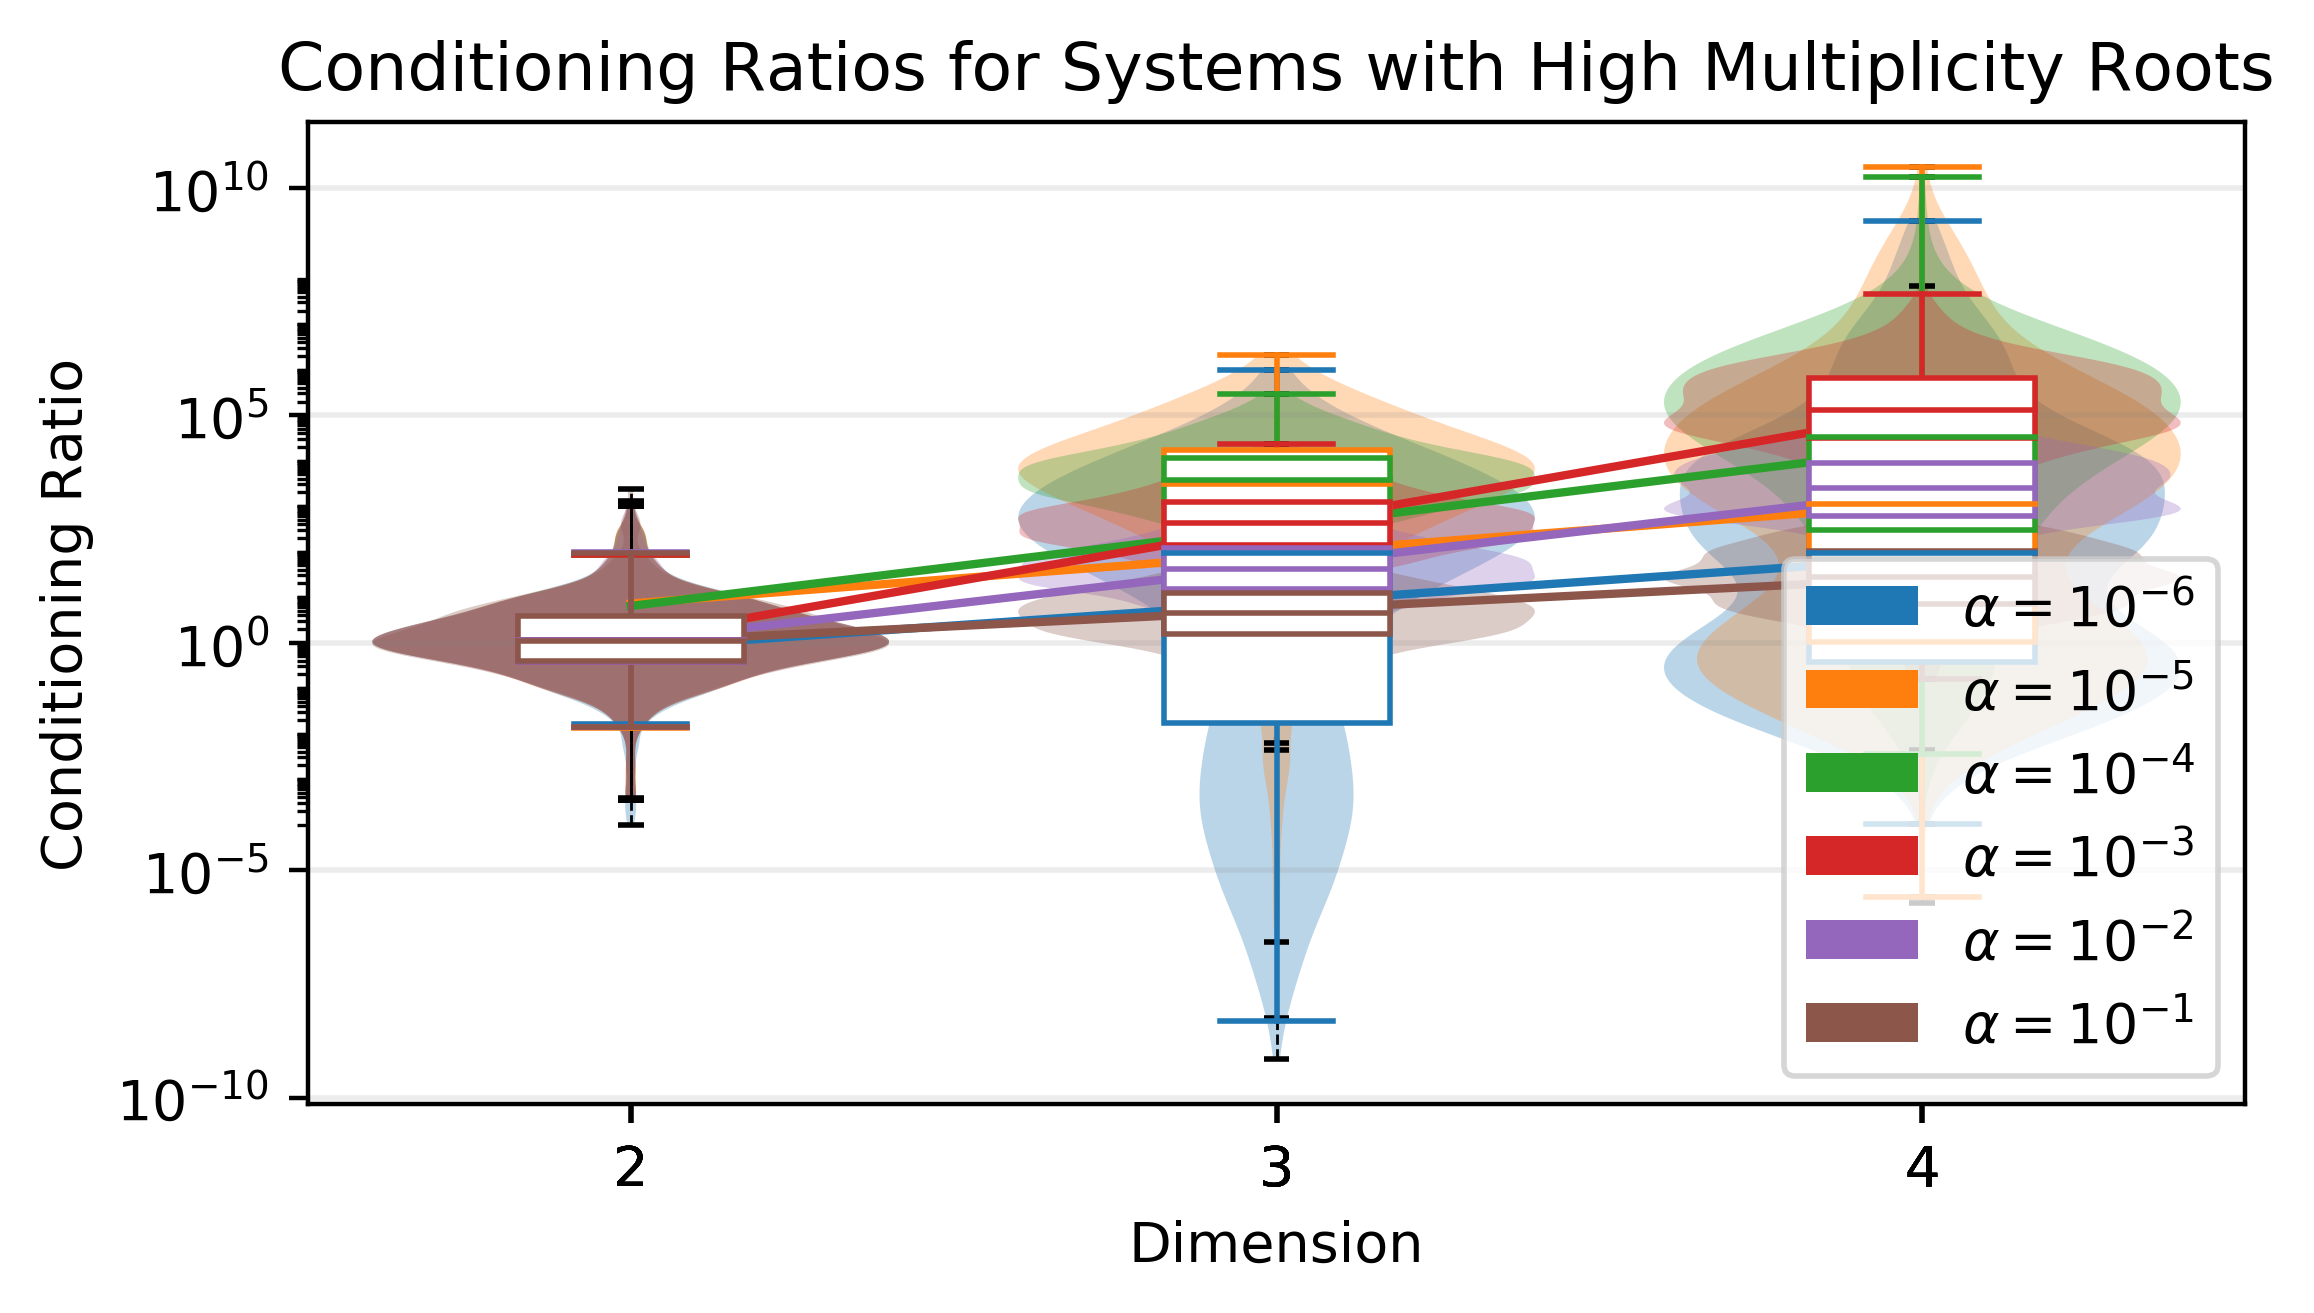

In [41]:
plot([mult6,
      mult5,
      mult4,
      mult3,
      mult2,
      mult1],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-5}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
     figsize=(6.25,3.25), 
     filename='high_multiplicity_cr', 
     title='Conditioning Ratios for Systems with High Multiplicity Roots',
     min_ylim=-4,
     max_ylim=8)

In [42]:
alphas = np.logspace(-6,-1)
alphaslopes_multiples, alphaslopes_doubles= [],[]
for alpha in alphas:
    print('alpha =',alpha,end='\r')
    #multiple roots
    data_multiples = get_data(alpha,gen_func=gen_almost_multiple_roots)
    data_multiples_log10 = [np.log10(data_multiples[d].flatten()) for d in data_multiples.keys()]
    points_multiples = np.array([[d,val] for i,d in enumerate(data_multiples.keys()) for val in data_multiples_log10[i]])
    slope_multiples = linregress(points_multiples)[0]
    alphaslopes_multiples.append(slope_multiples)
    
    #double roots
    data_doubles = get_data(alpha,gen_func=gen_almost_double_roots)
    data_doubles_log10 = [np.log10(data_doubles[d].flatten()) for d in data_doubles.keys()]
    points_doubles = np.array([[d,val] for i,d in enumerate(data_doubles.keys()) for val in data_doubles_log10[i]])
    slope_doubles = linregress(points_doubles)[0]
    alphaslopes_doubles.append(slope_doubles)

2lpha = 1e-06
3
4
2
3
4
2lpha = 1.2648552168552959e-06
3
4
2
3
4
2lpha = 1.5998587196060574e-06
3
4
2
3
4
2lpha = 2.0235896477251557e-06
3
4
2
3
4
2lpha = 2.5595479226995334e-06
3
4
2
3
4
2lpha = 3.2374575428176467e-06
3
4
2
3
4
2lpha = 4.094915062380427e-06
3
4
2
3
4
2lpha = 5.179474679231212e-06
3
4
2
3
4
2lpha = 6.5512855685955095e-06
3
4
2
3
4
2lpha = 8.286427728546843e-06
3
4
2
3
4
2lpha = 1.0481131341546853e-05
3
4
2
3
4
2lpha = 1.3257113655901109e-05
3
4
2
3
4
2lpha = 1.67683293681101e-05
3
4
2
3
4
2lpha = 2.1209508879201926e-05
3
4
2
3
4
2lpha = 2.6826957952797274e-05
3
4
2
3
4
2lpha = 3.39322177189533e-05
3
4
2
3
4
2lpha = 4.291934260128778e-05
3
4
2
3
4
2lpha = 5.4286754393238594e-05
3
4
2
3
4
2lpha = 6.866488450042999e-05
3
4
2
3
4
2lpha = 8.68511373751352e-05
3
4
2
3
4
2lpha = 0.00010985411419875583
3
4
2
3
4
2lpha = 0.00013894954943731373
3
4
2
3
4
2lpha = 0.0001757510624854793
3
4
2
3
4
2lpha = 0.00022229964825261955
3
4
2
3
4
2lpha = 0.0002811768697974231
3
4
2
3
4
2lpha

In [43]:
np.save('tests/conditioning_ratios/alphas',alphas)
np.save('tests/conditioning_ratios/alphaslopes_multiples',alphaslopes_multiples)
np.save('tests/conditioning_ratios/alphaslopes_doubles',alphaslopes_doubles)

$\alpha=10^{-4}$
Slope: 1.730204741283626 
Intercept: -2.653576420075135 
Exponential Growth Rate: 52.728503122746936

$\alpha=10^{-3}$
Slope: 2.478646441932547 
Intercept: -4.86158465630106 
Exponential Growth Rate: 300.0554141578218

$\alpha=10^{-2}$
Slope: 1.6411530646972594 
Intercept: -3.249835049141977 
Exponential Growth Rate: 42.76763345906044

$\alpha=10^{-1}$
Slope: 0.6996369129914483 
Intercept: -1.3882990479771373 
Exponential Growth Rate: 4.0076839679360265

$\alpha=5*10^{-4}$
Slope: 1.730204741283626 
Intercept: -2.653576420075135 
Exponential Growth Rate: 52.728503122746936



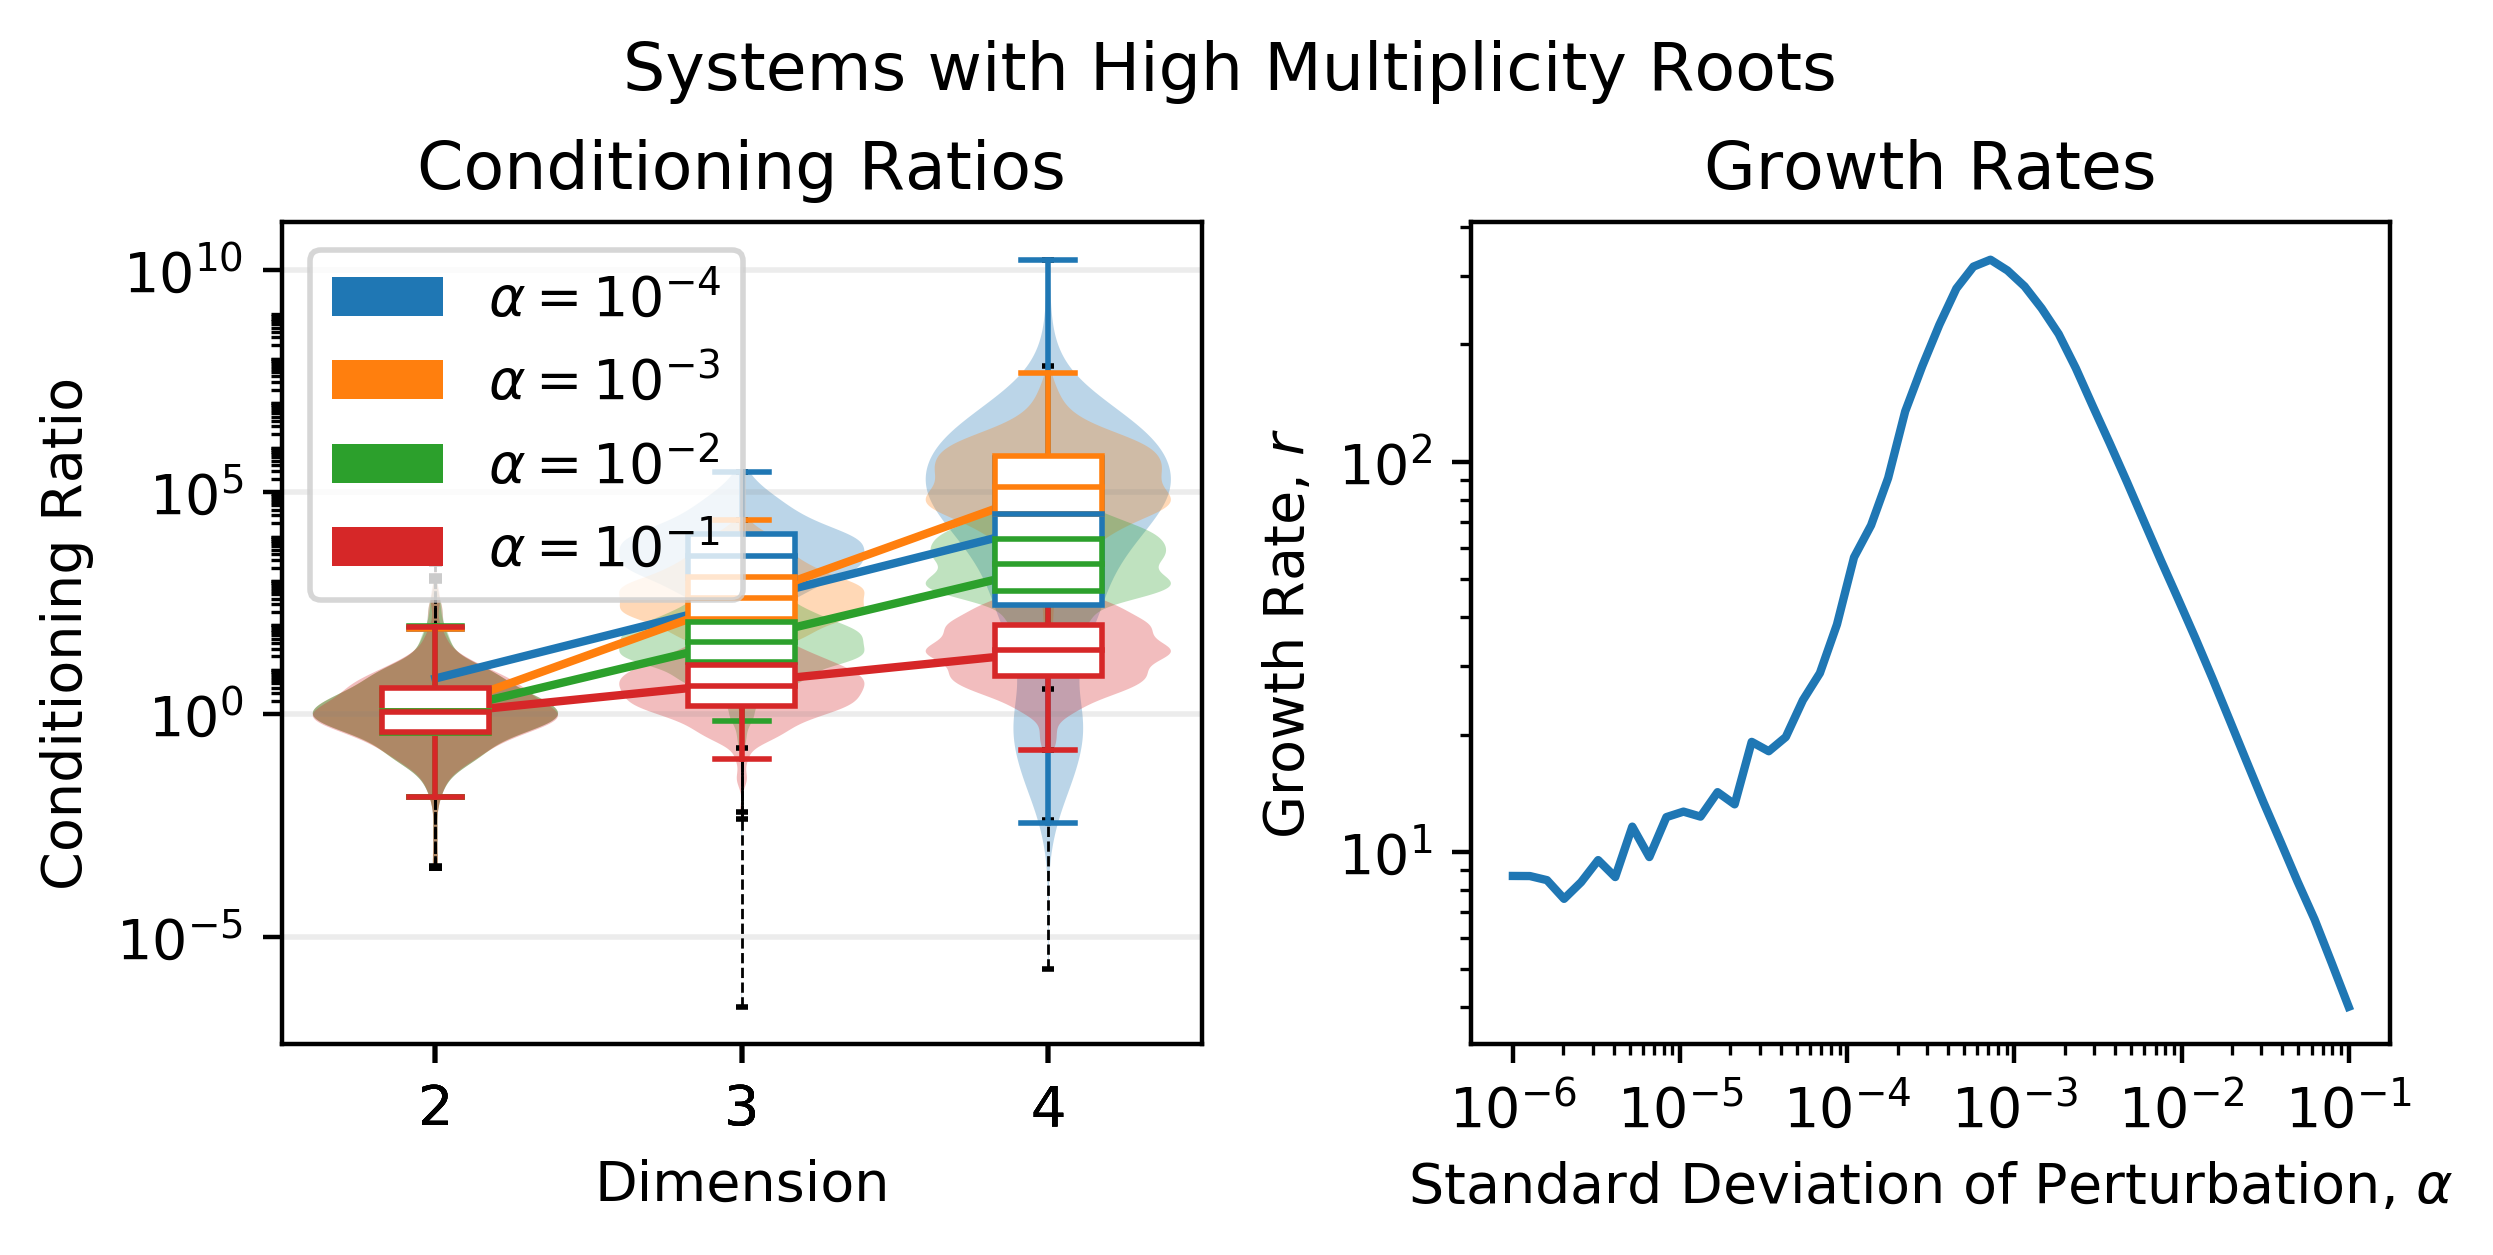

In [45]:
plot([[mult4,
      mult3,
      mult2,
      mult1],
     [mult4]],
     [[r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
      [r'$\alpha=5*10^{-4}$']],
     figsize=(6.25,3.25), filename='high_multiplicities_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'Systems with High Multiplicity Roots'],
     subplots=[1,2], _2nd_plot=[alphas,10**np.array(alphaslopes_multiples)-1],
     min_ylim=0,max_ylim=9)

### double, not multiple roots

In [47]:
doub1 = get_data(alpha=.1,gen_func=gen_almost_double_roots)

2
3
4


In [52]:
doub2 = get_data(alpha=.01,gen_func=gen_almost_double_roots)

2
3
4


In [49]:
doub3 = get_data(alpha=.001,gen_func=gen_almost_double_roots)

2
3
4


$\delta=10^{-3}$
Slope: -0.07392482273080075 
Intercept: 0.23354112520716486 
Exponential Growth Rate: -0.1565192466166937

$\delta=10^{-2}$
Slope: -0.07509277038116655 
Intercept: 0.23595269292247686 
Exponential Growth Rate: -0.15878457100359988

$\delta=10^{-1}$
Slope: -0.07814334290258908 
Intercept: 0.21943550847037846 
Exponential Growth Rate: -0.16467273474819855



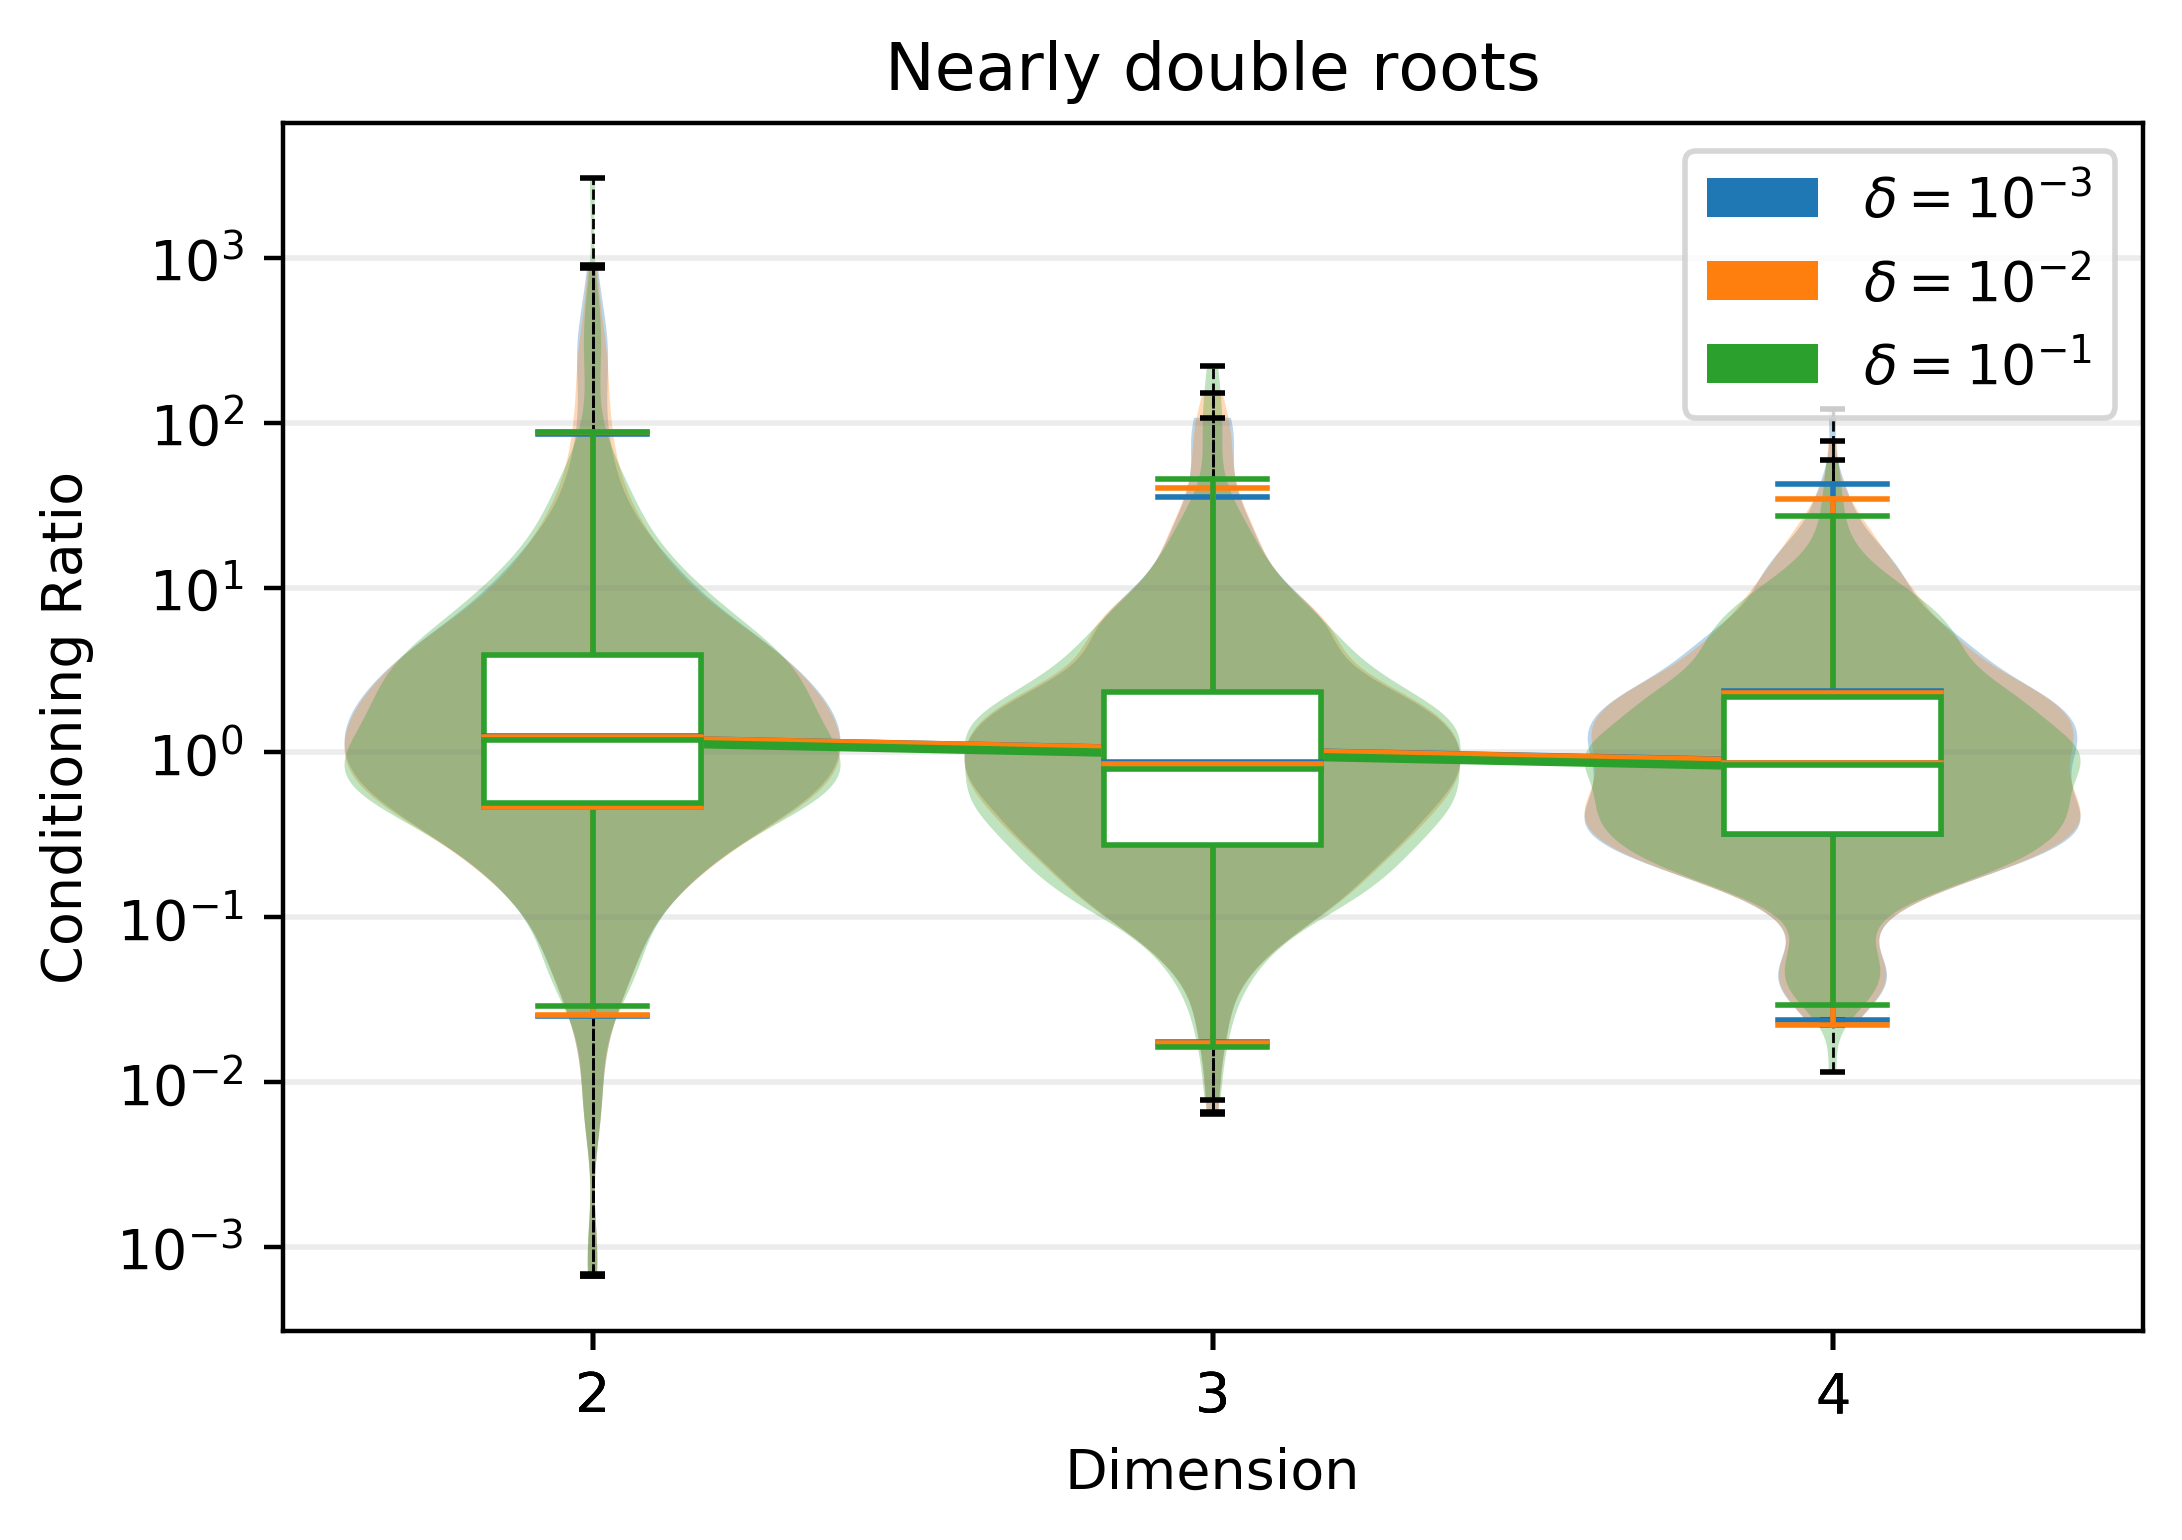

In [53]:
plot([doub3,doub2,doub1],
      [r'$\delta=10^{-3}$',
       r'$\delta=10^{-2}$',
       r'$\delta=10^{-1}$'],
     title = 'Nearly double roots', filename='nearly_double')

In [54]:
alphaslopes_doubles

[-0.07424644247157317,
 -0.07226681627569283,
 -0.07294929330397275,
 -0.07076609061231912,
 -0.0722018827533944,
 -0.07424013396170878,
 -0.07192307918897589,
 -0.0730037541170116,
 -0.07240513757193355,
 -0.07252259301193598,
 -0.07242940292471983,
 -0.07280632246426995,
 -0.0734160835273645,
 -0.07345620594026608,
 -0.07334035688500073,
 -0.07333597691561125,
 -0.07330360804289224,
 -0.07330771962939886,
 -0.07329137065142817,
 -0.07332212820752218,
 -0.07334391050317479,
 -0.07336024290852662,
 -0.07338418779070084,
 -0.0734121082258202,
 -0.07345018521390934,
 -0.07349810780687245,
 -0.0735608590018427,
 -0.07364110569936388,
 -0.07374206031393915,
 -0.07386735411984846,
 -0.0740192604558519,
 -0.07420078278313241,
 -0.07441732014906223,
 -0.07468082479538679,
 -0.07502464139124972,
 -0.07555573572338413,
 -0.07647855683013217,
 -0.07558434634042802,
 -0.07520523884213678,
 -0.07507586195319353,
 -0.07534670707507124,
 -0.07582336355005415,
 -0.07643510170502874,
 -0.0773951184625

# Generate Random Hyperconic Systems

In [56]:
rand1 = get_data(alpha=.1,gen_func=gen_rand_hyperconic)

2
3
4


Random Hyperconic Systems
Slope: -0.13122531415928243 
Intercept: 0.20854288104326085 
Exponential Growth Rate: -0.2607783363561693



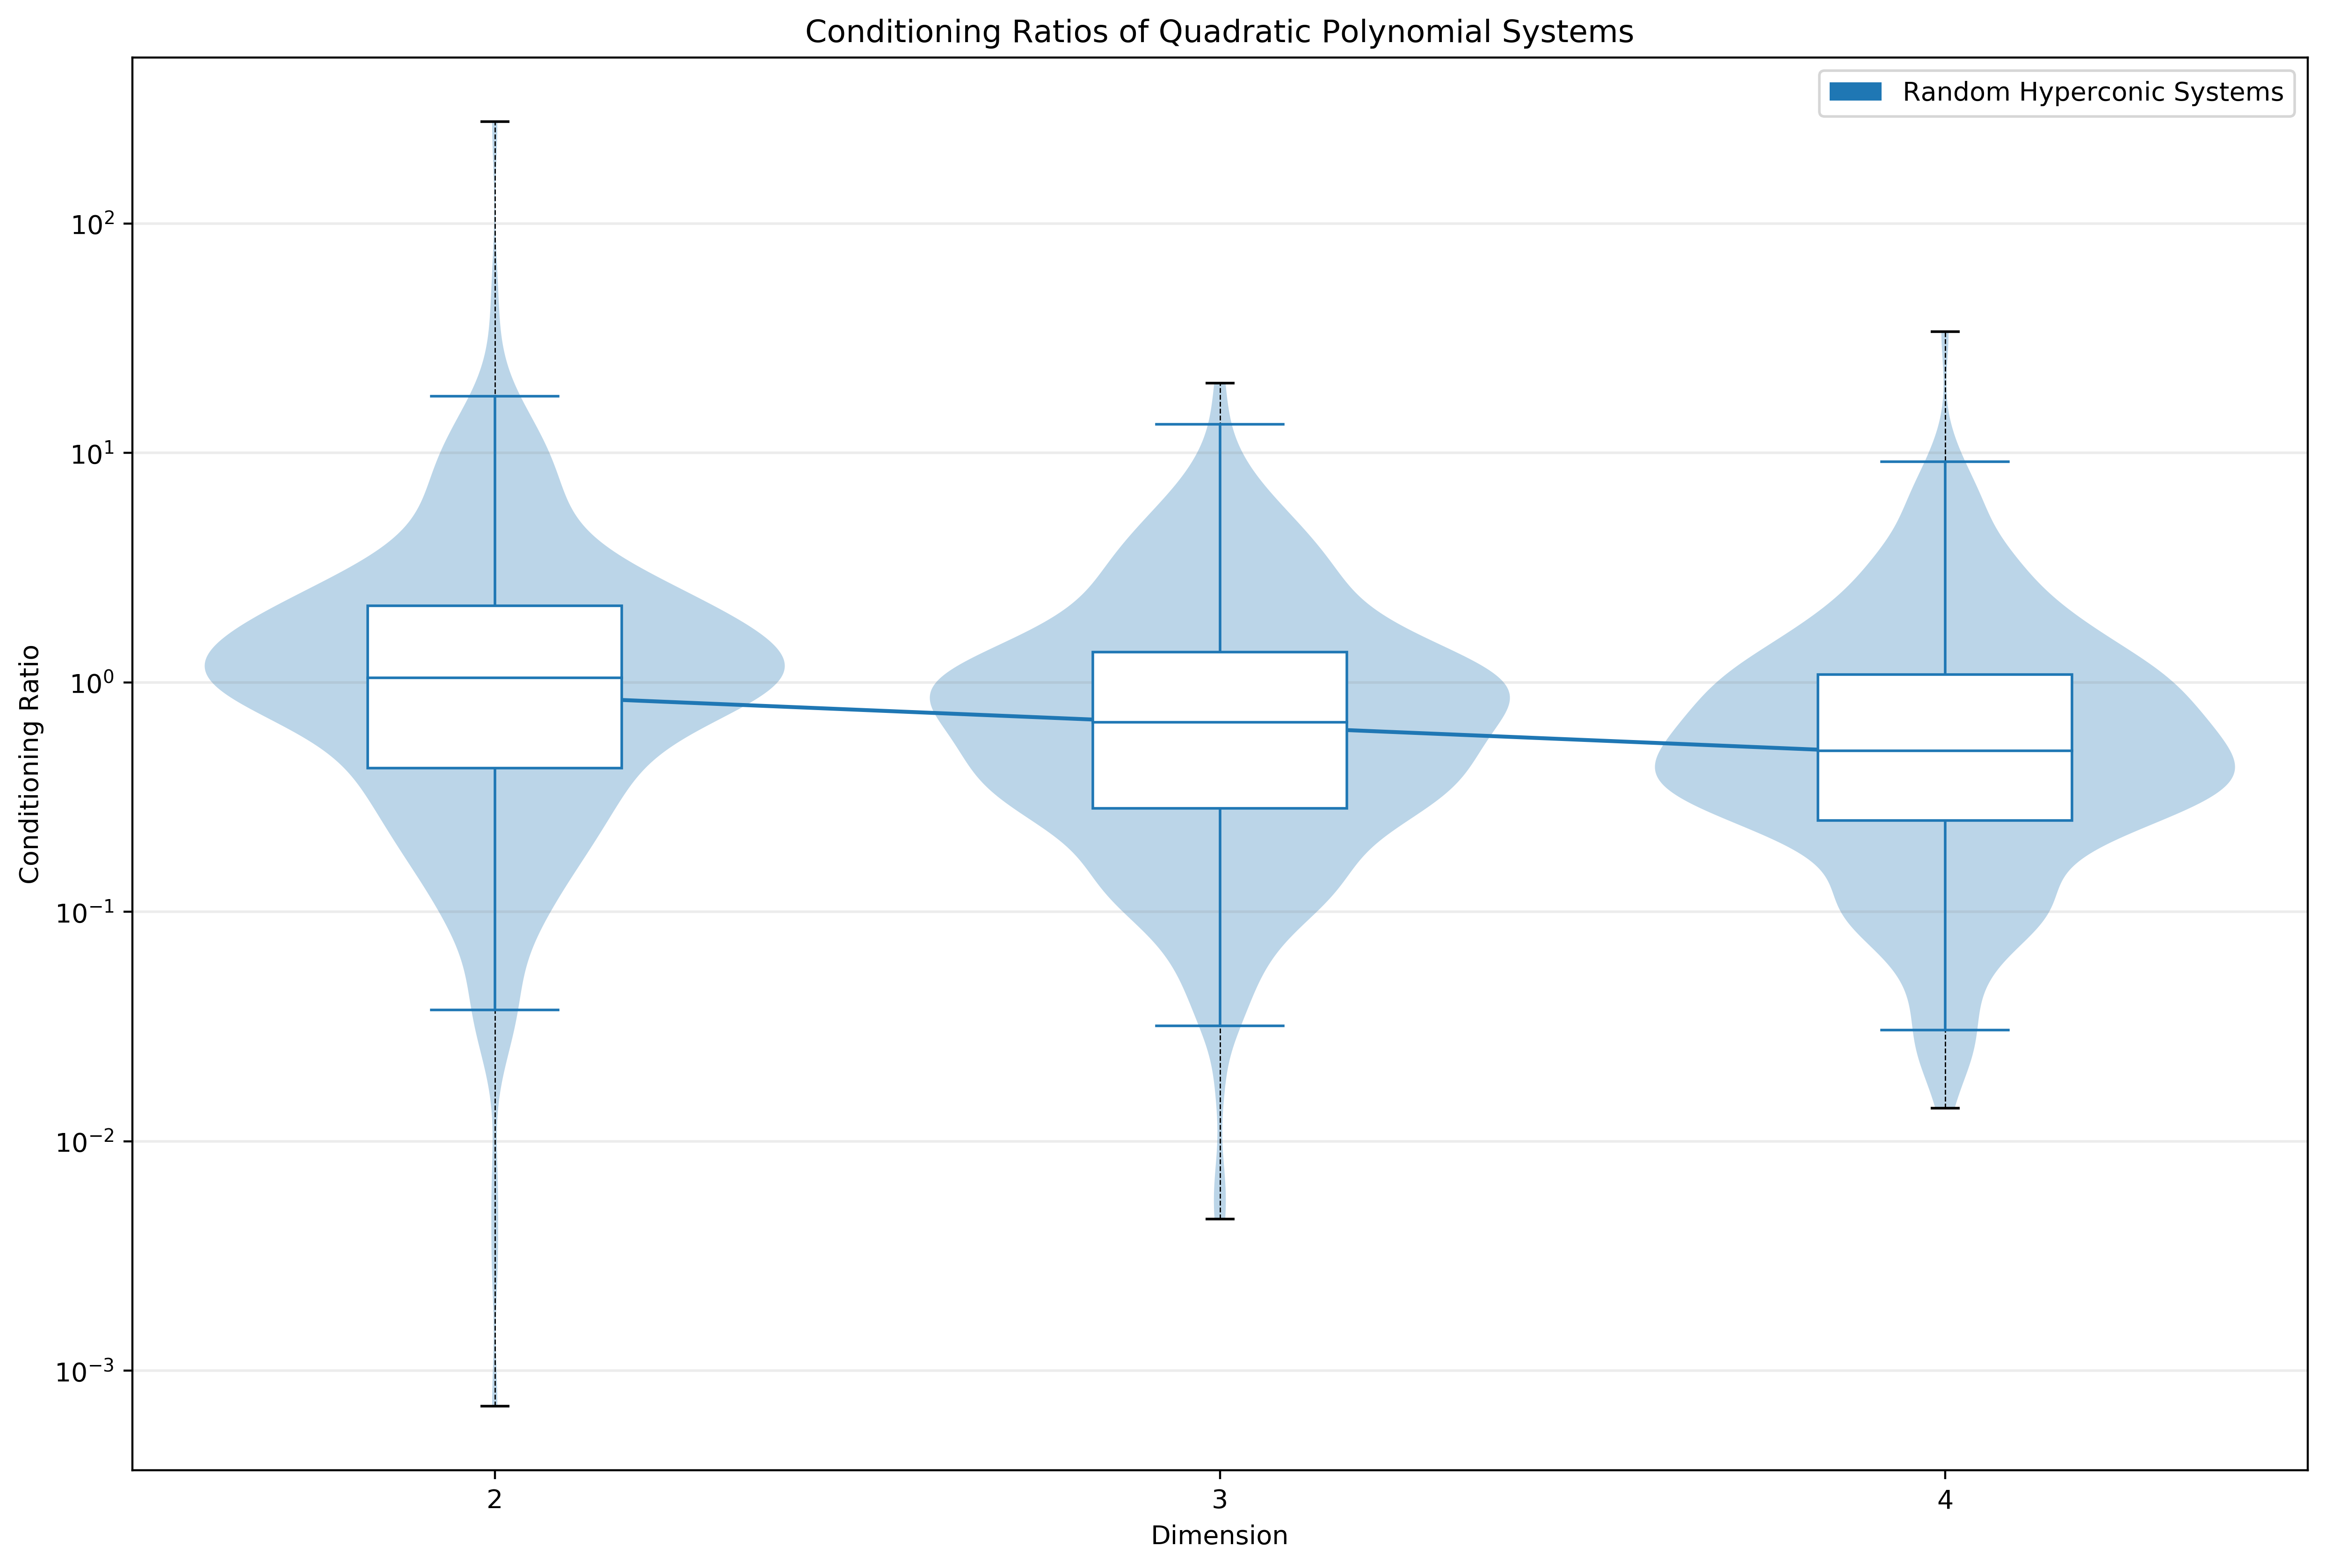

In [57]:
plot([rand1],
     [r'Random Hyperconic Systems'],
     figsize=(15,10), filename='random_hyperconic')

# trying to do extra precision